
# Markov Chain Monte Carlo

:::{post} Jan 7, 2024
:tags: statistical rethinking, bayesian inference, mcmc, hamiltonian monte carlo
:category: intermediate
:author: Dustin Stansbury
:::

This notebook is part of the PyMC port of the [Statistical Rethinking 2023](https://github.com/rmcelreath/stat_rethinking_2023) lecture series by Richard McElreath.

[Video - Lecture 08 - Markov Chain Monte Carlo](https://youtu.be/rZk2FqX2XnY)# [Lecture 08 - Markov Chain Monte Carlo](https://youtu.be/rZk2FqX2XnY?si=t4iSegXu8I6jtWUr)

In [1]:
# Ignore warnings
import warnings

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.formula.api as smf
import utils as utils
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib import style
from scipy import stats as stats

warnings.filterwarnings("ignore")

# Set matplotlib style
STYLE = "statistical-rethinking-2023.mplstyle"
style.use(STYLE)

# Real-world research

The real world is complicated, and requires more complex causal models. **Numerical methods that leverage random number generators provide the most practical way (currently) to estimate the posterior distributions for more complex causal models**

## Complexities due measurment and noise

### Example: marriage & divorce rate dataset
#### The graph we analyzed in Lecture 07

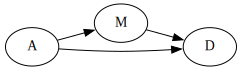

In [2]:
utils.draw_causal_graph(edge_list=[("M", "D"), ("A", "D"), ("A", "M")], graph_direction="LR")

#### However, the real-world graph is likely much more complex

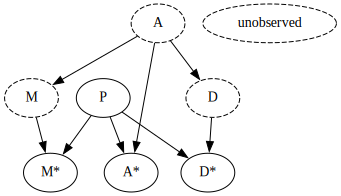

In [3]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "M"),
        ("A", "D"),
        ("A", "A*"),
        ("M", "M*"),
        ("D", "D*"),
        ("P", "A*"),
        ("P", "M*"),
        ("P", "D*"),
    ],
    node_props={
        "A": {"style": "dashed"},
        "D": {"style": "dashed"},
        "M": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
)

- We don't actually observe Marriage $M$, Divorce $D$, and Age $A$ directly, but rather noisy measurements associated with each $M*, D*, A*$.
- Besides measurement noise, there's also varying reliability due to the underlying Population $P$ that can affect our estimates of $M*, D*, A*$ take (e.g. smaller states have fewer observations, and thus less reliable estimates).

## Complexities due to latent, unobserved causes
### Example Testing Scores

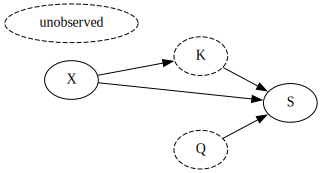

In [4]:
utils.draw_causal_graph(
    edge_list=[("K", "S"), ("X", "S"), ("X", "K"), ("Q", "S")],
    node_props={
        "K": {"style": "dashed"},
        "Q": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    graph_direction="LR",
)

- Test scores $S$ are a function of
  - observed student features $X$
  - unobserved knowledge state $K$
  - test quality/difficulty $Q$

## Social Networks

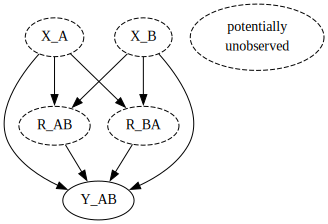

In [5]:
utils.draw_causal_graph(
    edge_list=[
        ("R_AB", "Y_AB"),
        ("R_BA", "Y_AB"),
        ("X_A", "Y_AB"),
        ("X_B", "Y_AB"),
        ("X_A", "R_AB"),
        ("X_A", "R_BA"),
        ("X_B", "R_AB"),
        ("X_B", "R_BA"),
    ],
    node_props={
        "X_A": {"style": "dashed"},
        "X_B": {"style": "dashed"},
        "R_AB": {"style": "dashed"},
        "R_BA": {"style": "dashed"},
        "potentially\nunobserved": {"style": "dashed"},
    },
)

- relationship from person or group $A$ to $B$, $R_{AB}$ may result in some outcome involving both $Y_{AB}$
  - e.g. $A$ could be an admirer of $B$
- similarly, but not necessarily symetrically $R_{BA}$ may result in some outcome involving both $Y_{AB}$
  - e.g. $B$ may not be an admirer of $A$
- There are also feartures of the people or groups $X_*$ that affect both the relationships and the outcomes
  - e.g. the wealth status of $A$ and/or $B$
- The interactions $Y_*$ do not occur between some other person or group $C$ presumably
- All of these non-outcome variables are potentially unobserved
- because of some social interaction structure. Given that we can only measure some of these outcomes, we must infer the network structure

## Problems and Solutions
### Additional Complexities in Real-world Research

The following can make calculating posteriors difficult

- many unknowns and unobserved
- nested relationships -- so far models have been more-or-less additive, this is not always the case
- bounded outcomes -- parameters that should have limited support
- difficult posterior calculation 
  - analytical approach -- rarely can we rely on closed-form mathematical solutions (e.g. conjugate prior scenarios)
  - grid approximation -- only works for small problems (curse of dimensionality)
  - quadratic approximation -- only works for subset of problems (e.g. multivariate Gaussian posteriors)
  - MCMC - general, but computationally expensive -- it has become more accessible with compute as of late.
 
## AnAlYzE tHe DaTa
Here we dig into the black box used to estimate posteriors during the estimation phase of the workflow.

### Computing the posterior
1. Analytical Approach -- often impossible (outside of conjugate priors)
2. Grid Approximation -- only pragmatic for small problems with few dimensions
3. Quadratic Approximation -- only works for posteriors that can be approximated by mult-variate Gaussians (no discrete variables)
4. Markov Chain Monte Carlo -- intensive, but not beyond modern computing capabilities



## King Markov vists the Metropolis Archipelago (aka Metropolis algorithm)

1. flip a coin to choose to go to left or right island
2. find population of proposal island $p_{proposal}$
3. find population of current island $p_{current}$
4. move to the proposal island with probability $\frac{p_{proposal}}{p_{current}}$
5. repeat 1-4

- In the long run, this process will visit each island in proportion to its population
- If we use island population as a metaphor for probability density, then we can use the same algorithm to sample from any probability distribution (of any number of dimensions) using a random number generator
- For Bayesian inference, we apply the the Metropolis alogirthm assuming:
  - islands $\rightarrow$ parameter values
  - population size $\rightarrow$ posterior probability
 
## Markov Chain Monte Carlo
- **Chain**: sequence of draws from a proposal distribution
- **_Markov_ Chain**: history doesn't matter, only the current state of the parameter
- **Monte Carlow**: a reference to randomization a' la' gambling in the town of Monte Carlo

In [6]:
def simulate_markov_visits(island_sizes, n_steps=100_000):
    """aka Metropolis algorithm"""

    # Metropolis algorithm
    island_idx = np.arange(len(island_sizes))
    visits = {ii: 0 for ii in island_idx}
    current_island_idx = np.random.choice(island_idx)
    markov_chain = []  # store history
    for _ in range(n_steps):

        # 1. Flip a coin to propose a direction, left or right
        coin_flip = np.random.rand() > 0.5
        direction = -1 if coin_flip else 1
        proposal_island_idx = np.roll(island_idx, direction)[current_island_idx]

        # 2. Proposal island size
        proposal_size = island_sizes[proposal_island_idx]

        # 3. Current island size
        current_size = island_sizes[current_island_idx]

        # 4. Go to proposal island if ratio of sizes is greater than another coin flip
        p_star = proposal_size / current_size
        move = np.random.rand() < p_star
        current_island_idx = proposal_island_idx if move else current_island_idx

        # 5. tally visits and repeat
        visits[current_island_idx] += 1
        markov_chain.append(current_island_idx)

    # Visualization
    island_idx = visits.keys()
    island_visit_density = [v / n_steps for v in visits.values()]
    island_size_density = island_sizes / island_sizes.sum()

    _, axs = plt.subplots(1, 2, figsize=(12, 4))

    plt.sca(axs[0])
    plt.plot(island_sizes, lw=3, color="C0")
    plt.xlabel("Island Index")
    plt.ylabel("Island Population")
    plt.xticks(np.arange(len(island_sizes)))

    plt.sca(axs[1])
    plt.plot(island_idx, island_size_density, color="C0", lw=3, label="Population")
    plt.bar(island_idx, island_visit_density, color="k", width=0.4, label="Visits")

    plt.xlabel("Island Index")
    plt.ylabel("Density")
    plt.xticks(np.arange(len(island_sizes)))

    plt.legend()
    return markov_chain


def plot_markov_chain(markov_chain, **hist_kwargs):
    _, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    plt.sca(axs[0])
    plt.plot(markov_chain[:300])
    plt.xlabel("visit number")
    plt.ylabel("island index")
    plt.title("Metropolis Algorithm Markov Chain\nFirst 300 Steps")

    plt.sca(axs[1])
    plt.hist(markov_chain, orientation="horizontal", density=True, **hist_kwargs)
    plt.title("Resulting Posterior\n(horizontal)");

### Verify Algorithm approximates Gaussian distribution centered on center island

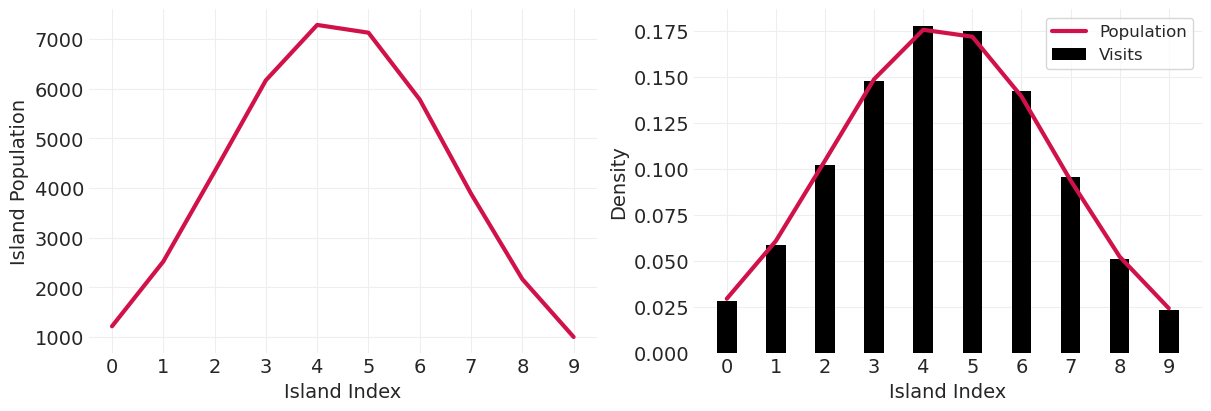

In [7]:
n_steps = 100_000
island_sizes = stats.norm(20, 10).pdf(np.linspace(1, 40, 10))
island_sizes /= island_sizes.min() / 1000

gaussian_markov_chain = simulate_markov_visits(island_sizes, n_steps)

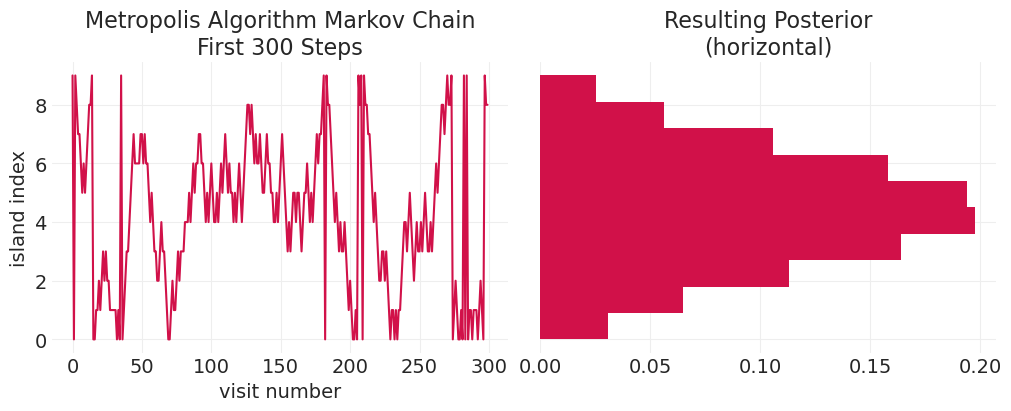

In [8]:
plot_markov_chain(gaussian_markov_chain, bins=10)

### Verify on Poisson distribution

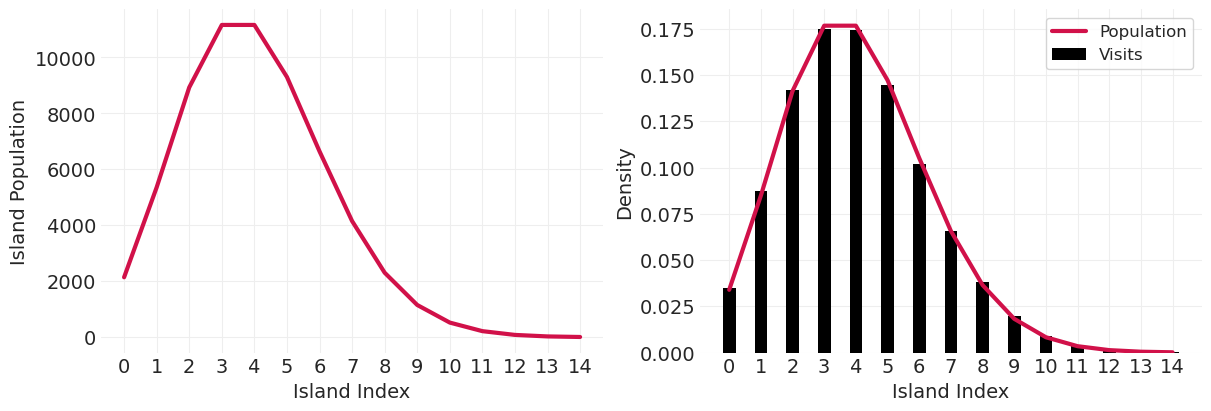

In [9]:
island_sizes = stats.poisson(5).pmf(np.linspace(1, 15, 15))
island_sizes /= island_sizes.min() / 10

poisson_markov_chain = simulate_markov_visits(island_sizes, n_steps);

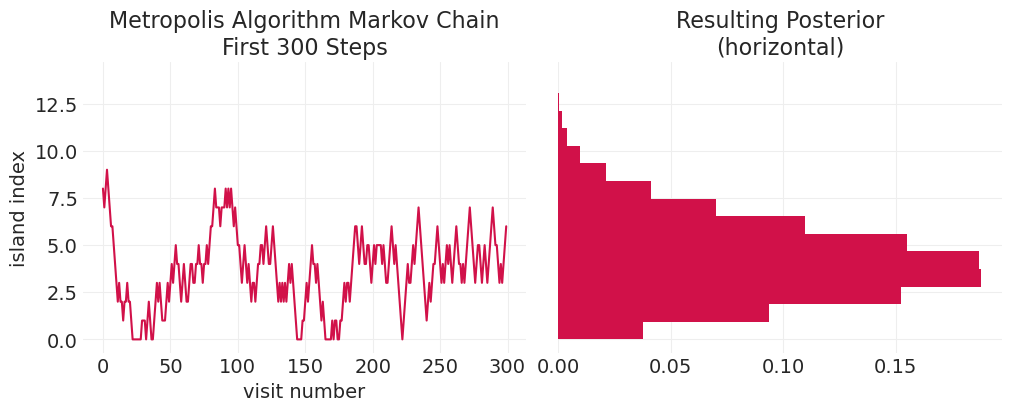

In [10]:
plot_markov_chain(poisson_markov_chain, bins=15)

### Verify for more exotic Bimodal distribution

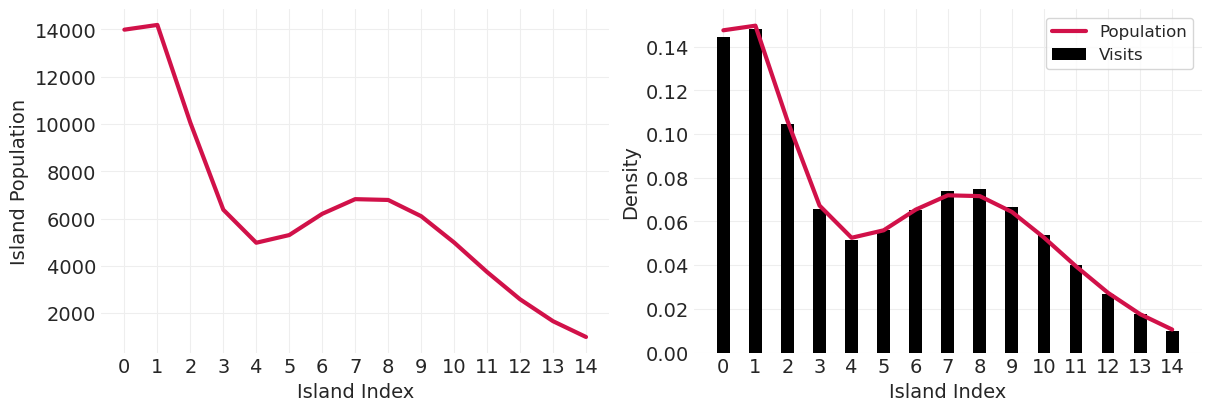

In [11]:
island_sizes = stats.poisson(2).pmf(np.linspace(1, 15, 15)) + stats.poisson(9).pmf(
    np.linspace(1, 15, 15)
)
island_sizes /= island_sizes.min() / 1000

bimodal_markov_chain = simulate_markov_visits(island_sizes, n_steps);

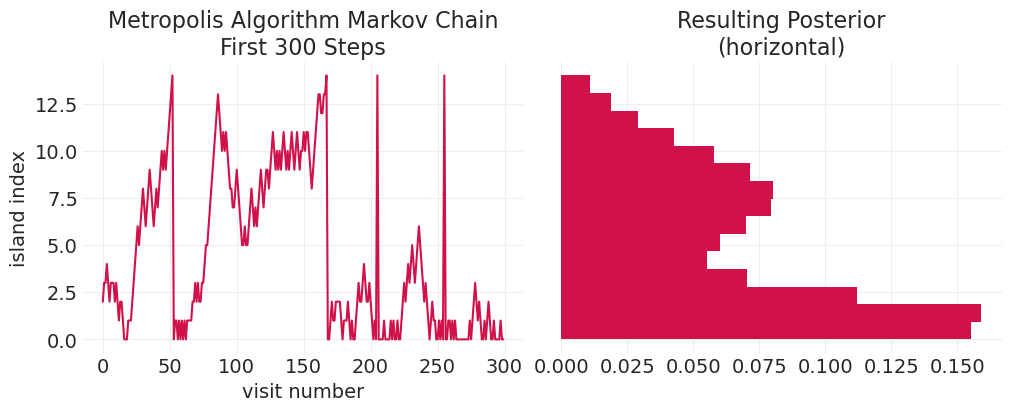

In [12]:
plot_markov_chain(bimodal_markov_chain, bins=15)

### Shoutout to Arianna Rosenbluth
- performed the actual implementation of the original MCMC algorithm in code
- implemented on MANIAC computer in the 1950s
- We should probably call it the **Rosenbluth algorithm**

### Basic Rosenbluth Algorithm

In [13]:
def simulate_metropolis_algorithm(
    n_steps=100, step_size=1.0, mu=0, sigma=0.5, resolution=100, random_seed=1
):
    np.random.seed(random_seed)

    # set up parameter grid
    mu_grid = np.linspace(-3.0, 3.0, resolution)
    sigma_grid = np.linspace(0.1, 3.0, resolution)

    mus, sigmas = np.meshgrid(mu_grid, sigma_grid)
    mus = mus.ravel()
    sigmas = sigmas.ravel()

    # Distribution over actual parameters
    mu_dist = stats.norm(mu, 1)
    sigma_dist = stats.lognorm(sigma)

    # Proposal distribution for each parameter
    mu_proposal_dist = stats.norm(0, 0.25)
    sigma_proposal_dist = stats.norm(0, 0.25)

    def evaluate_log_pdf(m, s):
        log_pdf_mu = mu_dist.logpdf(m)
        log_pdf_sigma = sigma_dist.logpdf(s)
        return log_pdf_mu + log_pdf_sigma

    def calculate_acceptance_probability(current_mu, current_sigma, proposal_mu, proposal_sigma):
        current_log_prob = evaluate_log_pdf(current_mu, current_sigma)
        proposal_log_prob = evaluate_log_pdf(proposal_mu, proposal_sigma)

        return np.exp(np.min([0, proposal_log_prob - current_log_prob]))

    # Contour plot of the joint distribution over parameters
    log_pdf_mu = mu_dist.logpdf(mus)
    log_pdf_sigma = sigma_dist.logpdf(sigmas)

    joint_log_pdf = log_pdf_mu + log_pdf_sigma
    joint_pdf = np.exp(joint_log_pdf - joint_log_pdf.max())

    plt.contour(
        mus.reshape(resolution, resolution),
        np.log(sigmas).reshape(resolution, resolution),
        joint_pdf.reshape(resolution, resolution),
        cmap="gray_r",
    )

    # Run the Metropolis algorithm
    current_mu = np.random.choice(mus)
    current_sigma = np.random.choice(sigmas)

    accept_count = 0
    reject_count = 0
    for step in range(n_steps):

        # Propose a new location in parameter space nearby to the current params
        proposal_mu = current_mu + mu_proposal_dist.rvs() * step_size
        proposal_sigma = current_sigma + sigma_proposal_dist.rvs() * step_size

        # Accept proposal?
        acceptance_prob = calculate_acceptance_probability(
            current_mu, current_sigma, proposal_mu, proposal_sigma
        )
        if acceptance_prob >= np.random.rand():
            accept_label = "accepted" if accept_count == 0 else None
            plt.scatter(
                (current_mu, proposal_mu),
                (np.log(current_sigma), np.log(proposal_sigma)),
                color="C0",
                alpha=0.25,
                label=accept_label,
            )
            plt.plot(
                (current_mu, proposal_mu),
                (np.log(current_sigma), np.log(proposal_sigma)),
                color="C0",
                alpha=0.25,
            )
            current_mu = proposal_mu
            current_sigma = proposal_sigma
            accept_count += 1
        else:
            reject_label = "rejected" if reject_count == 0 else None
            plt.scatter(
                (current_mu, proposal_mu),
                (np.log(current_sigma), np.log(proposal_sigma)),
                color="black",
                alpha=1,
                label=reject_label,
            )
            reject_count += 1

    accept_rate = accept_count / n_steps

    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$log \; \sigma$")
    plt.xlim([mus.min(), mus.max()])
    plt.ylim([np.log(sigmas.min()), np.log(sigmas.max())])
    plt.title(f"step size: {step_size}; accept rate: {accept_rate}")
    plt.legend()

### Effect of step size

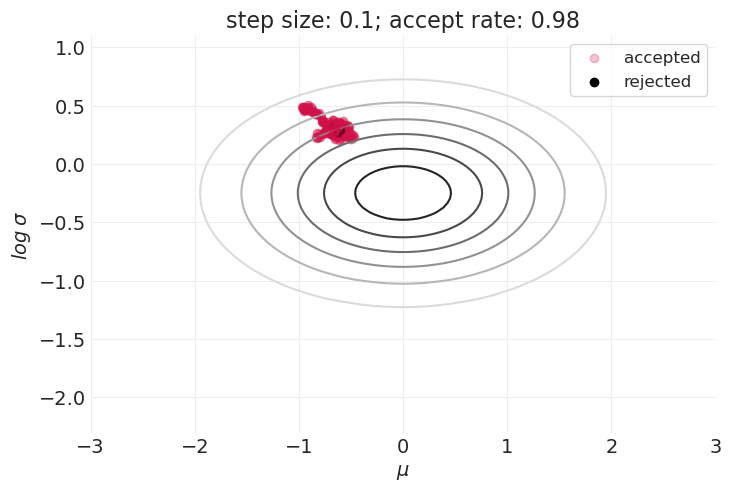

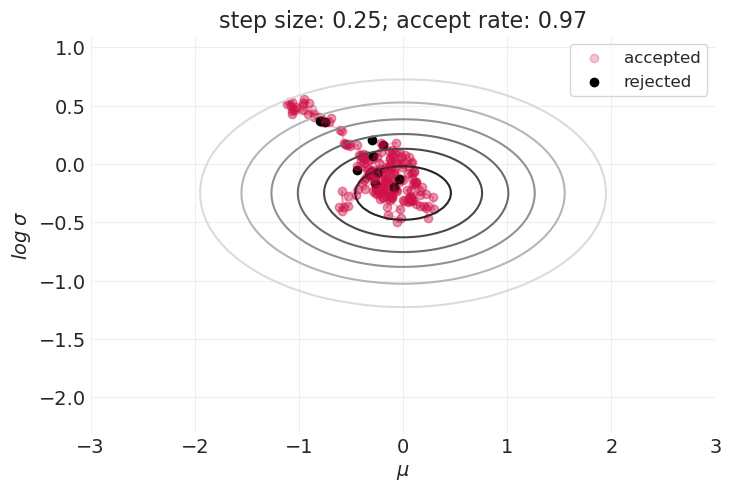

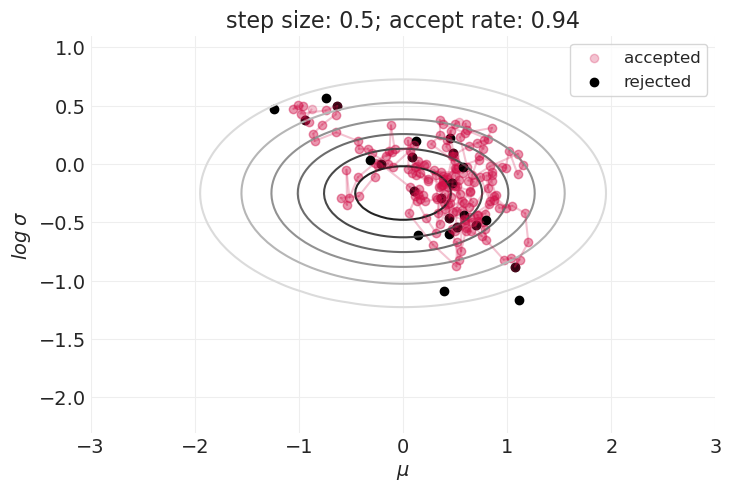

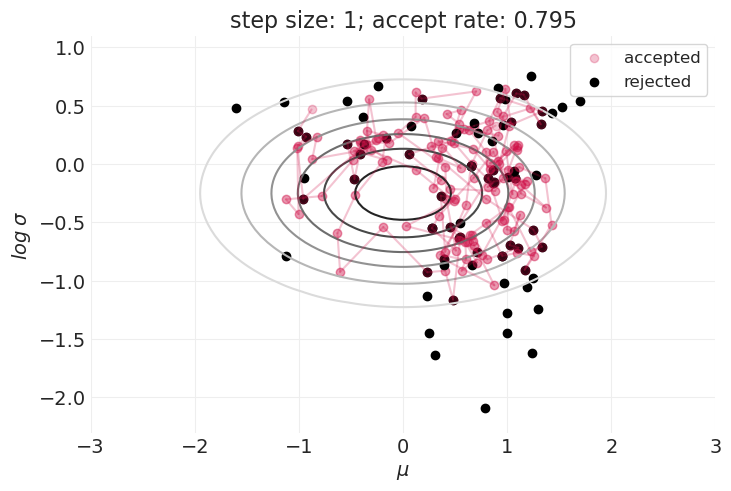

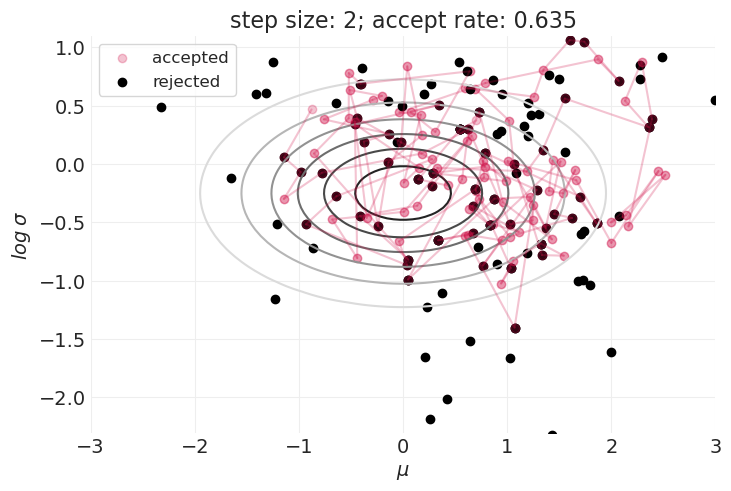

In [14]:
for step_size in [0.1, 0.25, 0.5, 1, 2]:
    plt.figure()
    simulate_metropolis_algorithm(step_size=step_size, n_steps=200)

#### Metropolis algorithm is great in that it

- is quite simple
- is general -- it can be applied to any distribution

#### However, it comes with some major downsides
- As shown above, there is a tradeoff between exploring the shape of the distribution, and accepting samples.
  - this only gets worse in models with higher dimensional parameters space.
- Large rejection rate of samples can make the Metropolis the algorithm prohibitive to use in practice.

## Hamiltonian aka "Hybrid" Monte Carlo (HMC) 🛹

HMC is a more efficient sampling algorithm that takes advantage of gradient information about the posterior in order to make sampling more efficient -- exploring more of the space, while also accepting more proposed samples. It does so by associating each location in parameter space with a position in a physical simulation space. We then run a physics simulation using Hamiltonian dynamics, which is formulated in terms of position and momentum of a particle traveling on a surface. At any point on the surface the particle will have a potential energy U and kinetic energy K that are traded back and forth due to conservation of energy. HMC uses this energy conservation to simulate the dynamics.



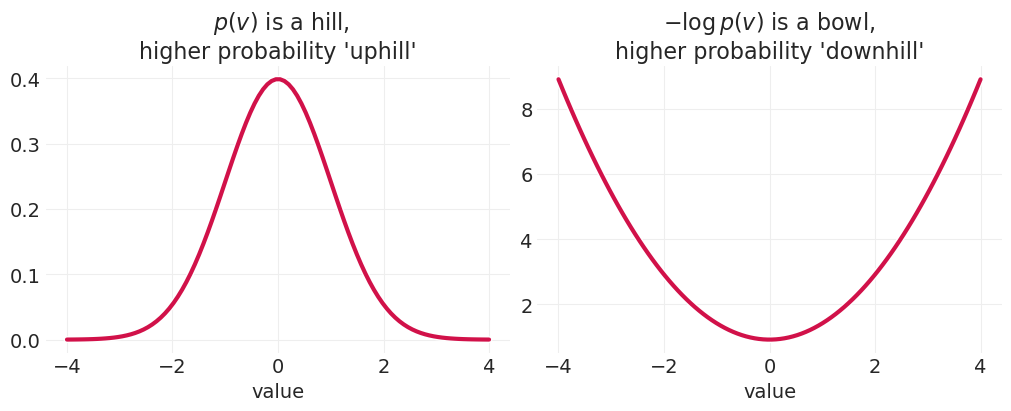

In [15]:
demo_posterior = stats.norm
values = np.linspace(-4, 4, 100)
pdf = demo_posterior.pdf(values)
neg_log_pdf = -demo_posterior.logpdf(values)
_, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axs[0])
utils.plot_line(values, pdf, label="PDF")
plt.xlabel("value")
plt.title("$\\ p(v)$ is a hill,\nhigher probability 'uphill'")

plt.sca(axs[1])
utils.plot_line(values, neg_log_pdf, label="PDF")
plt.xlabel("value")
plt.title("$-\\log p(v)$ is a bowl,\nhigher probability 'downhill'");

### HMC requires a few components:
- A function `U(position)` that returns the the "potential energy" from the physical dynamics perspective. This is the same to the negative log posterior given the data and current parameters. 
- The gradient of `U(position)`, `dU(position)`, which provides the partial derivatives with respect to potential energy / parameters, given the data samples and the current parameters state.
- A function `K(momentum)` that returns the potential energy given the current momentum of the simulated particle.


For more details, see my (now ancient) [blog post on MCMC: Hamiltonian Monte Carlo](https://theclevermachine.wordpress.com/2012/11/18/mcmc-hamiltonian-monte-carlo-a-k-a-hybrid-monte-carlo/)


In [16]:
from functools import partial


def U_(x, y, theta, a=0, b=1, c=0, d=1):
    """
    Potential energy / negative log-posterior given current parameters, theta.
    a, b and c, d are the mean and variance of prior distributions for mu_x and
    mu_y, respectively
    """
    mu_x, mu_y = theta

    # Gaussian log priors
    log_prior_mu_x = stats.norm(a, b).logpdf(mu_x)
    log_prior_mu_y = stats.norm(c, d).logpdf(mu_y)

    # Gaussian log likelihoods
    log_likelihood_x = np.sum(stats.norm(mu_x, 1).logpdf(x))
    log_likelihood_y = np.sum(stats.norm(mu_y, 1).logpdf(y))

    # log posterior
    log_posterior = log_likelihood_x + log_likelihood_y + log_prior_mu_x + log_prior_mu_y

    # potential energy is negative log posterior
    return -log_posterior


def dU_(x, y, theta, a=0, b=1, c=0, d=1):
    """
    Gradient of potential energy with respect to current parameters, theta.
    a, b and c, d are the mean and variance of prior distributions for mu_x and
    mu_y, respectively
    """
    mu_x, mu_y = theta

    # Note: we implicitly divide by likelihood (left) term
    # of the gradient by the likelihood variance, which is 1
    dU_dmu_x = np.sum(x - mu_x) + (a - mu_x) / b**2
    dU_dmu_y = np.sum(y - mu_y) + (c - mu_y) / d**2
    return np.array((-dU_dmu_x, -dU_dmu_y))


def K(momentum):
    """Kinetic energy given a current momentum state"""
    return np.sum(momentum**2) / 2

Each step of HMC involves "flicking" a partical, inducing it with a particular momentum (velocity and direction), then allowing the partical to "roll" around the surface of the energy landscape. The direction the partical takes at any point in time is given by the function `dU()`. To simulate nonlinear motion along the landscape, we take multiple consecutive linear steps (aka "leapfrog" steps). After a set number of steps are taken, we than calcualte the total energy of the system, which is a combination of potential energy, given by `U()`, and kinetic energy, which can be calculated directly from the state of the momementum. If the potential energy state (negative log posterior) after simulation is lower than the potential energy of the initial state (before the dynamics), then we randomly accept the new state of the parameters in proportion to the energy change.

In [17]:
def HMC(current_theta, U, dU, step_size, n_leapfrog_steps):
    """Propose/accept a parameter sample using Hamiltonian / Hybrid Monte Carlo"""
    n_parameters = len(current_theta)

    # Initial "position" and "momentum"
    position = current_theta
    momentum = stats.norm().rvs(n_parameters)  # random flick

    current_momentum = momentum

    # Take a half step at beginning
    momentum -= (step_size / 2) * dU(theta=position)

    # Simulate nonlinear dynamics with linear leapfrog steps
    for step in range(n_leapfrog_steps - 1):
        position += step_size * momentum
        momentum -= step_size * dU(theta=position)

    # Take half step at the end
    momentum -= (step_size / 2) * dU(theta=position)

    # Negate momentum at end for symmetric proposal
    momentum *= -1

    # Calculate potential/kinetic energies at beginning / end of simulation
    current_U = U(theta=current_theta)
    current_K = K(current_momentum)

    proposed_U = U(theta=position)
    proposed_K = K(momentum)

    # Acceptance criterion
    acceptance_probability = np.exp(
        np.min([0, (current_U - proposed_U) + (current_K - proposed_K)])
    )
    if acceptance_probability > np.random.rand():
        new_theta = position
        accept = 1
    else:
        new_theta = current_theta
        accept = 0

    return new_theta, accept


def simulate_hybrid_monte_carlo(
    mu=np.array((20, 10)),
    covariance=np.eye(2),
    n_samples=10,
    n_steps=100,
    step_size=0.01,
    n_leapfrog_steps=11,
    resolution=100,
    random_seed=123,
):
    """
    Simulate running HMC sampler to estimate the parameters mu = (mu_x and mu_y).
    """
    np.random.seed(random_seed)

    # The true data distribution
    data_dist = stats.multivariate_normal(mu, covariance)

    # Sample data points from the true distribution -- this will guide the posterior
    dataset = data_dist.rvs(n_samples).T
    x = dataset[0]
    y = dataset[1]

    # Parameter grid for visualization
    mux, muy = mu[0], mu[1]
    mux_grid = np.linspace(mux - mux * 0.25, mux + mux * 0.25, resolution)
    muy_grid = np.linspace(muy - muy * 0.25, muy + muy * 0.25, resolution)

    xs, ys = np.meshgrid(mux_grid, muy_grid)
    xs = xs.ravel()
    ys = ys.ravel()

    # Plot the true data distribution and samples
    true_pdf = data_dist.pdf(np.vstack([xs, ys]).T)
    _, axs = plt.subplots(1, 2, figsize=(8, 4))
    plt.sca(axs[0])
    plt.contour(
        xs.reshape(resolution, resolution),
        ys.reshape(resolution, resolution),
        true_pdf.reshape(resolution, resolution),
        cmap="gray_r",
    )
    plt.scatter(x, y, color="C1", label="data")

    plt.xlim([xs.min(), xs.max()])
    plt.ylim([ys.min(), ys.max()])
    plt.xlabel("x")
    plt.ylabel("y")

    # Display HMC dynamics
    plt.sca(axs[1])

    # Add true pdf to dynamics plot
    plt.contour(
        xs.reshape(resolution, resolution),
        ys.reshape(resolution, resolution),
        true_pdf.reshape(resolution, resolution),
        cmap="gray_r",
    )

    # Initialize the potential energy and gradient functions with the data points
    U = partial(U_, x=x, y=y)
    dU = partial(dU_, x=x, y=y)

    # Use datapoint as random starting point
    current_theta = np.array((np.random.choice(x), np.random.choice(y)))
    accept_count = 0
    reject_count = 0
    for step in range(n_steps):

        # Run Hybrid Monte Carlo Step
        proposed_theta, accept = HMC(current_theta, U, dU, step_size, n_leapfrog_steps)

        # Plot sampling progress
        if accept:
            accept_label = "accepted" if accept_count == 0 else None

            plt.scatter(
                (current_theta[0], proposed_theta[0]),
                (current_theta[1], proposed_theta[1]),
                color="C0",
                alpha=0.25,
                label=accept_label,
            )
            plt.plot(
                (current_theta[0], proposed_theta[0]),
                (current_theta[1], proposed_theta[1]),
                color="C0",
                alpha=0.25,
            )
            current_theta = proposed_theta
            accept_count += 1
        else:
            reject_label = "rejected" if reject_count == 0 else None
            plt.scatter(
                proposed_theta[0], proposed_theta[1], color="black", alpha=0.25, label=reject_label
            )
            reject_count += 1

    accept_rate = accept_count / n_steps

    # Show true parameters
    plt.axvline(mux, linestyle="--", color="C2", label="actual $\\mu_x$")
    plt.axhline(muy, linestyle="--", color="C3", label="actual $\\mu_y$")

    # Style
    plt.xlim([mux - mux * 0.1, mux + mux * 0.1])
    plt.ylim([muy - muy * 0.1, muy + muy * 0.1])
    plt.xlabel("$\\mu_x$")
    plt.ylabel("$\\mu_y$")
    plt.title(f"step size: {step_size}; accept rate: {accept_rate}")
    plt.legend(loc="lower right")

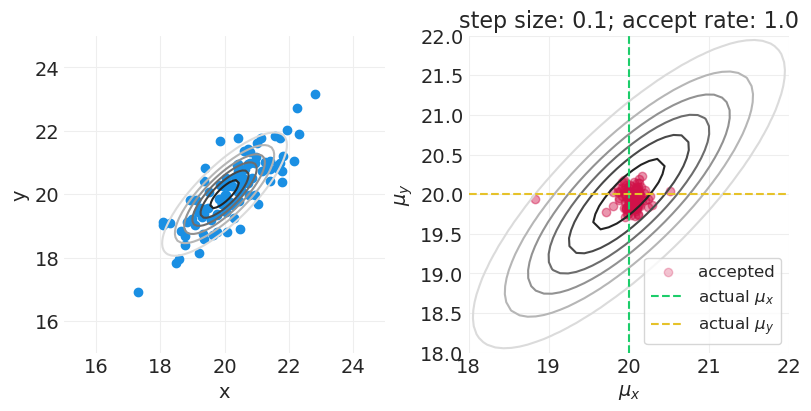

In [18]:
simulate_hybrid_monte_carlo(
    mu=np.array((20, 20)),
    covariance=np.array([[1.0, 0.8], [0.8, 1.0]]),
    n_samples=100,
    n_steps=100,
    step_size=0.1,
    n_leapfrog_steps=11,
    random_seed=12,
)

## Calculus is a Superpower
### Autodiff
For the HMC examples above, our (log) posterior / potential energy had a specific functional form (namely a mult-dimensional Gaussian), and we we had to use specific gradients and code for calculating those gradients that are aligned with that posterior. This custom approach to inference is approach generally prohibitive in that

- it takes a lot of work to calculate the gradient with respect to each parameter
- you have to recode (and debug) the algorithm for each model

**Autodiff** allows us to use any posterior function, giving us the gradients for free. Basically the function is broken down into a computation chain of the most basic mathematical operations. Each basic operation has its own simple derivative, so we can chain these derivatives together to provide the gradient of the entire function with respect to any parameter **automatically**.

### Stan / PyMC

McElreath uses Stan (accessed via R) to access autodiff and run general Bayesian inference. We're use PyMC, an analogous probabilistic programming language (PPL).

# 2012 New Jersey Wine Judgement
- 20 wines
  - 10 French, 10 NJ
- 9 French & American Judges
- 180 total scores
  - wines
    - 100 NJ
    - 80 FR
  - judges
    - 108 NJ
    - 72 FR

In [19]:
WINES = utils.load_data("Wines2012")
WINES.head()

judge flight wine  score  wine.amer  judge.amer
0  Jean-M Cardebat  white   A1   10.0          1           0
1  Jean-M Cardebat  white   B1   13.0          1           0
2  Jean-M Cardebat  white   C1   14.0          0           0
3  Jean-M Cardebat  white   D1   15.0          0           0
4  Jean-M Cardebat  white   E1    8.0          1           0

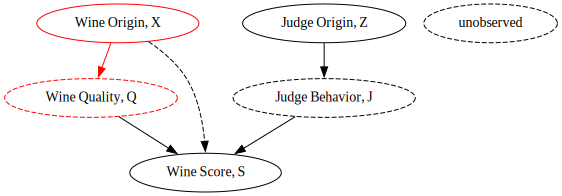

In [20]:
utils.draw_causal_graph(
    edge_list=[("Q", "S"), ("X", "Q"), ("X", "S"), ("J", "S"), ("Z", "J")],
    node_props={
        "Q": {"label": "Wine Quality, Q", "style": "dashed", "color": "red"},
        "J": {"label": "Judge Behavior, J", "style": "dashed"},
        "X": {"label": "Wine Origin, X", "color": "red"},
        "S": {"label": "Wine Score, S"},
        "Z": {"label": "Judge Origin, Z"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={("X", "S"): {"style": "dashed"}, ("X", "Q"): {"color": "red"}},
)

## Estimand
- Association between **Wine Quality and Wine Origin**
- Stratify by judge (not required) for efficiency

## Simplest Model

Make sure to start simple

$$
\begin{align*}
S_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= Q_{W[i]} \\
Q_{W[i]} &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

Note that Quality $Q_{W_[i]}$ is an unobserved, _latent_ variable.

In [21]:
# Define & preprocess data / coords

# Continuous, standardized wine scores
SCORES = utils.standardize(WINES.score).values

# Categorical judge ID
JUDGE_ID, JUDGE = pd.factorize(WINES.judge)

# Categorical wine ID
WINE_ID, WINE = pd.factorize(WINES.wine)

# Categorical wine origin
WINE_ORIGIN_ID, WINE_ORIGIN = pd.factorize(
    ["US" if w == 1.0 else "FR" for w in WINES["wine.amer"]], sort=False
)

### Fit the simple, wine-specific model

In [22]:
with pm.Model(coords={"wine": WINE}) as simple_model:

    sigma = pm.Exponential("sigma", 1)
    Q = pm.Normal("Q", 0, 1, dims="wine")  # Wine ID
    mu = Q[WINE_ID]
    S = pm.Normal("S", mu, sigma, observed=SCORES)
    simple_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Q]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


#### Posterior Summary

In [23]:
az.summary(simple_inference)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Q[A1]  0.135  0.329  -0.447    0.778      0.003    0.005   11039.0    2969.0   
Q[B1]  0.274  0.328  -0.369    0.875      0.003    0.004    9868.0    2969.0   
Q[C1] -0.121  0.319  -0.704    0.474      0.003    0.005    9702.0    2878.0   
Q[D1]  0.292  0.321  -0.292    0.896      0.004    0.004    8275.0    2700.0   
Q[E1]  0.085  0.321  -0.521    0.695      0.003    0.006   10652.0    2742.0   
Q[F1] -0.013  0.317  -0.606    0.583      0.003    0.006   10452.0    2963.0   
Q[G1] -0.110  0.307  -0.648    0.489      0.003    0.005    9953.0    3314.0   
Q[H1] -0.218  0.316  -0.824    0.347      0.004    0.004    7694.0    2506.0   
Q[I1] -0.144  0.329  -0.743    0.481      0.003    0.005    9632.0    2801.0   
Q[J1] -0.162  0.322  -0.776    0.435      0.003    0.005    9654.0    2855.0   
Q[A2]  0.104  0.309  -0.455    0.701      0.003    0.005    8660.0    3420.0   
Q[B2]  0.561  0.312  -0.047    1.112      0.003    0.003   11413.0    3002.0   
Q[C2] -0.371  0.311  -0.944    0.222      0.003    0.003   12525.0    2978.0   
Q[D2]  0.271  0.315  -0.340    0.829      0.003    0.004    8610.0    3113.0   
Q[E2]  0.121  0.326  -0.478    0.734      0.003    0.005   10737.0    2991.0   
Q[F2] -0.030  0.315  -0.596    0.579      0.003    0.006    9762.0    2874.0   
Q[G2]  0.008  0.323  -0.608    0.599      0.003    0.006   10383.0    2651.0   
Q[H2] -0.198  0.318  -0.791    0.384      0.003    0.005   10027.0    2909.0   
Q[I2] -0.856  0.328  -1.504   -0.277      0.003    0.003   10050.0    2731.0   
Q[J2]  0.387  0.318  -0.199    1.014      0.003    0.004    9533.0    2864.0   
sigma  1.000  0.054   0.905    1.110      0.001    0.000    6766.0    2798.0   

       r_hat  
Q[A1]   1.00  
Q[B1]   1.00  
Q[C1]   1.00  
Q[D1]   1.00  
Q[E1]   1.01  
Q[F1]   1.00  
Q[G1]   1.00  
Q[H1]   1.00  
Q[I1]   1.00  
Q[J1]   1.00  
Q[A2]   1.00  
Q[B2]   1.00  
Q[C2]   1.00  
Q[D2]   1.00  
Q[E2]   1.00  
Q[F2]   1.00  
Q[G2]   1.00  
Q[H2]   1.00  
Q[I2]   1.00  
Q[J2]   1.00  
sigma   1.00

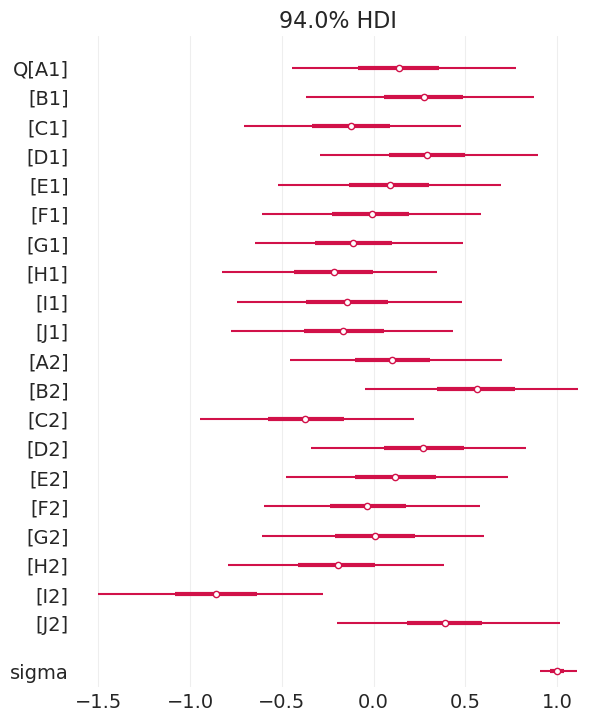

In [24]:
az.plot_forest(simple_inference, combined=True);

# Drawing the Markov Owl 🦉
## Convergence Evaluation
1. Trace Plots
2. Trace Rank Plots
3. R-hat Convergence Measure
4. n_effective Samples
5. Divergent Transitions

### 1. Trace Plots
Look for
- "fuzzy caterpillar"
  - "wandering" paths indicate too small step size (large number of acceptance, but exploring only local space)
  - long periods of same value indicate too large step size (large number of rejections, not exploring space)
- Each param should have similar density across chains
 

#### Looking at all parameters separately

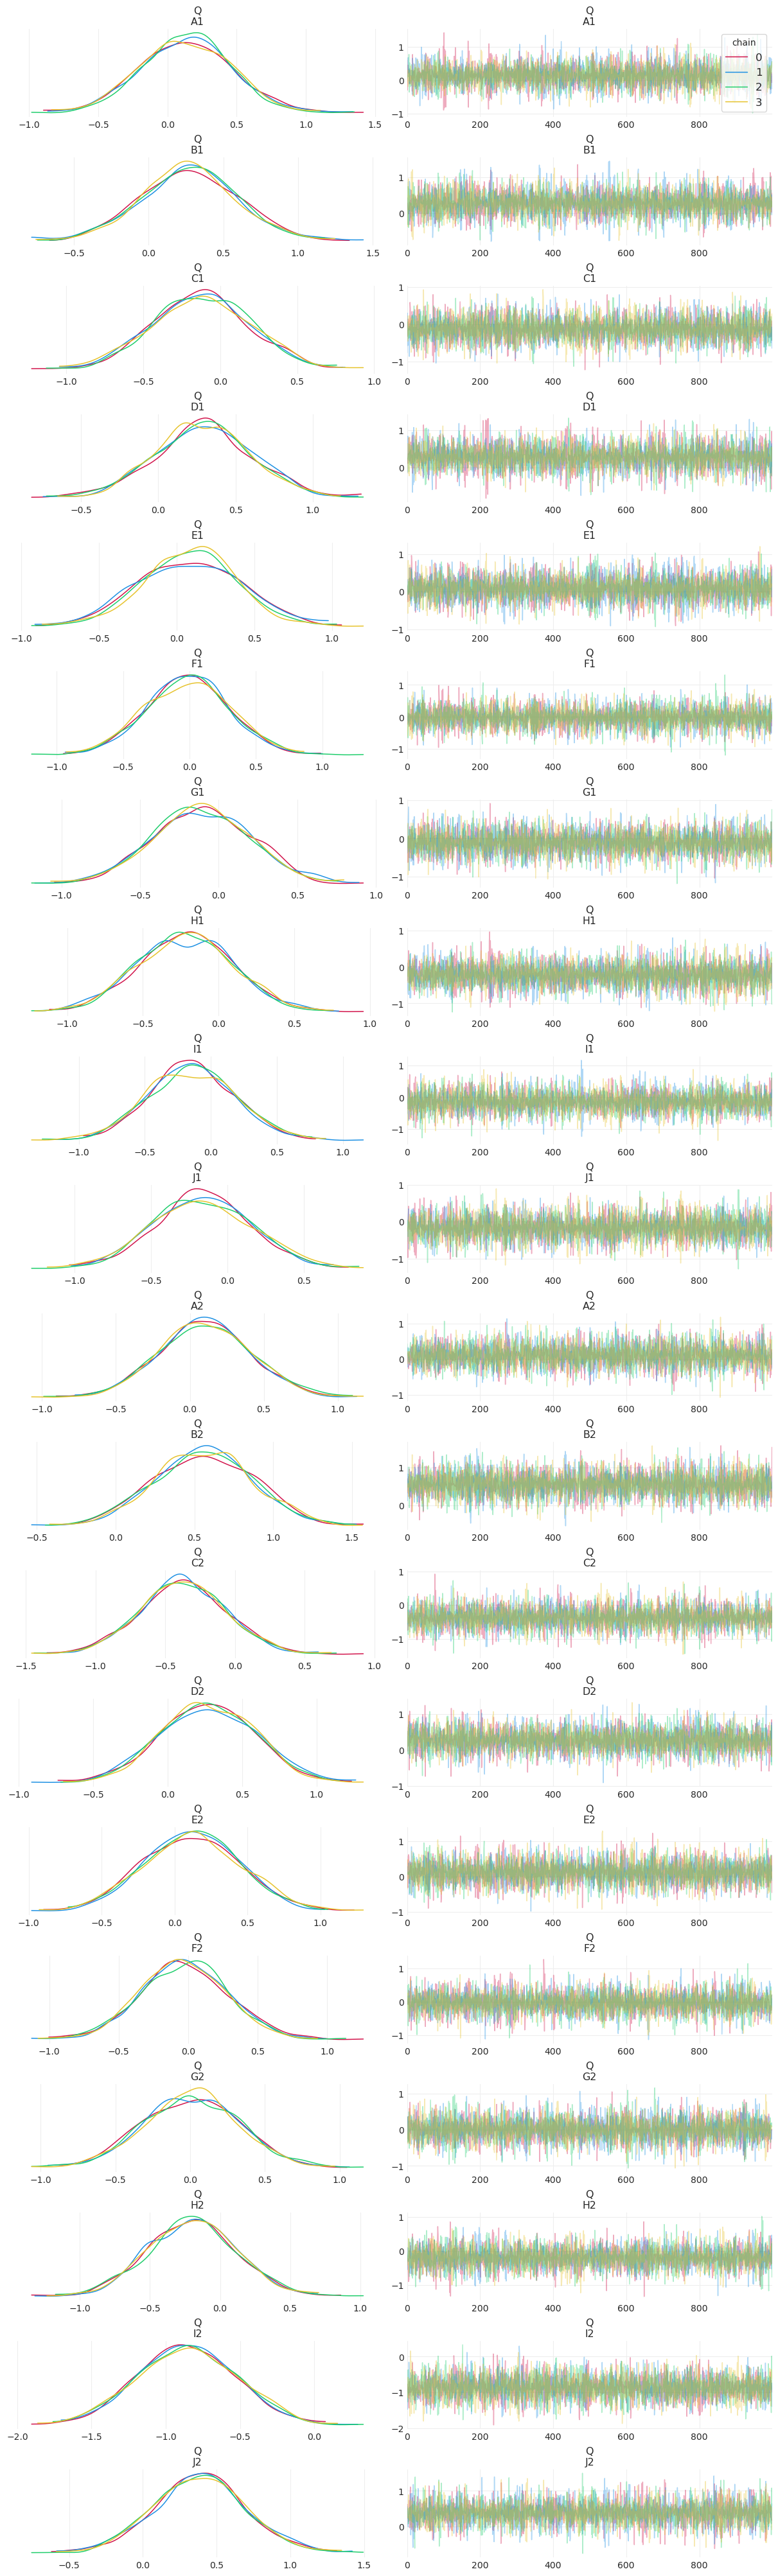

In [25]:
az.plot_trace(simple_inference, compact=False, legend=True);

so many fuzzy caterpillars!

> If HMC is sampling correctly, you'll only need a few hundred samples to get a good idea of the shape of the posterior. This is because, under the correct initial conditions and model parameterization, HMC is very efficient.

#### That's a lot of information! Try Compact Form

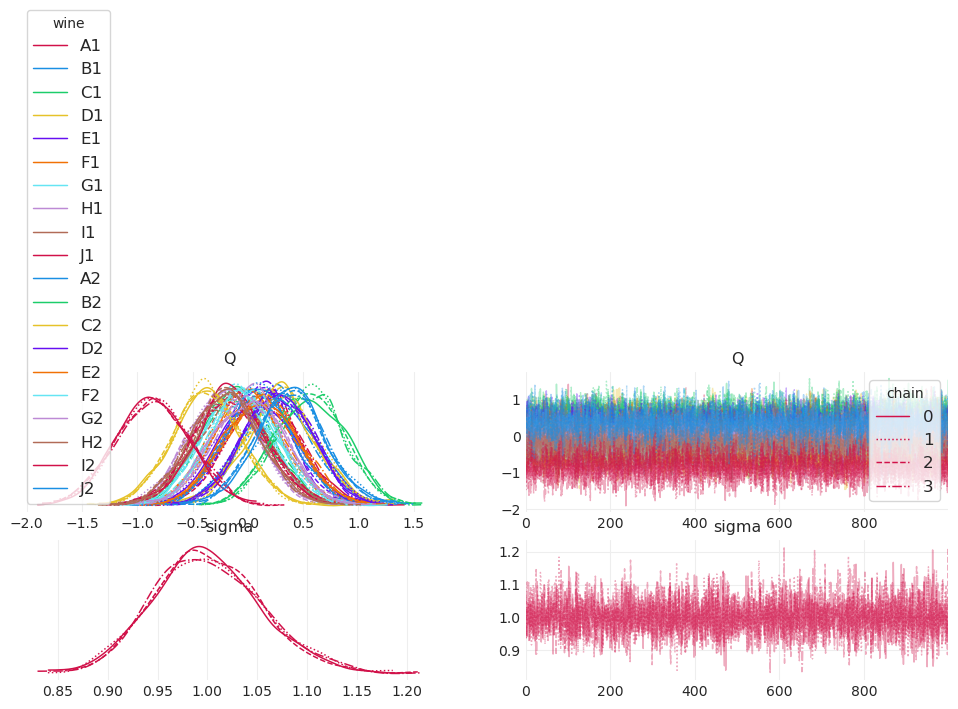

In [26]:
az.plot_trace(simple_inference, compact=True, legend=True);

## 2. Trace Rank "Trank" Plots
- Don't want any one chain having largest or smallest rank for extended period of time.
- "jumbled up" is good

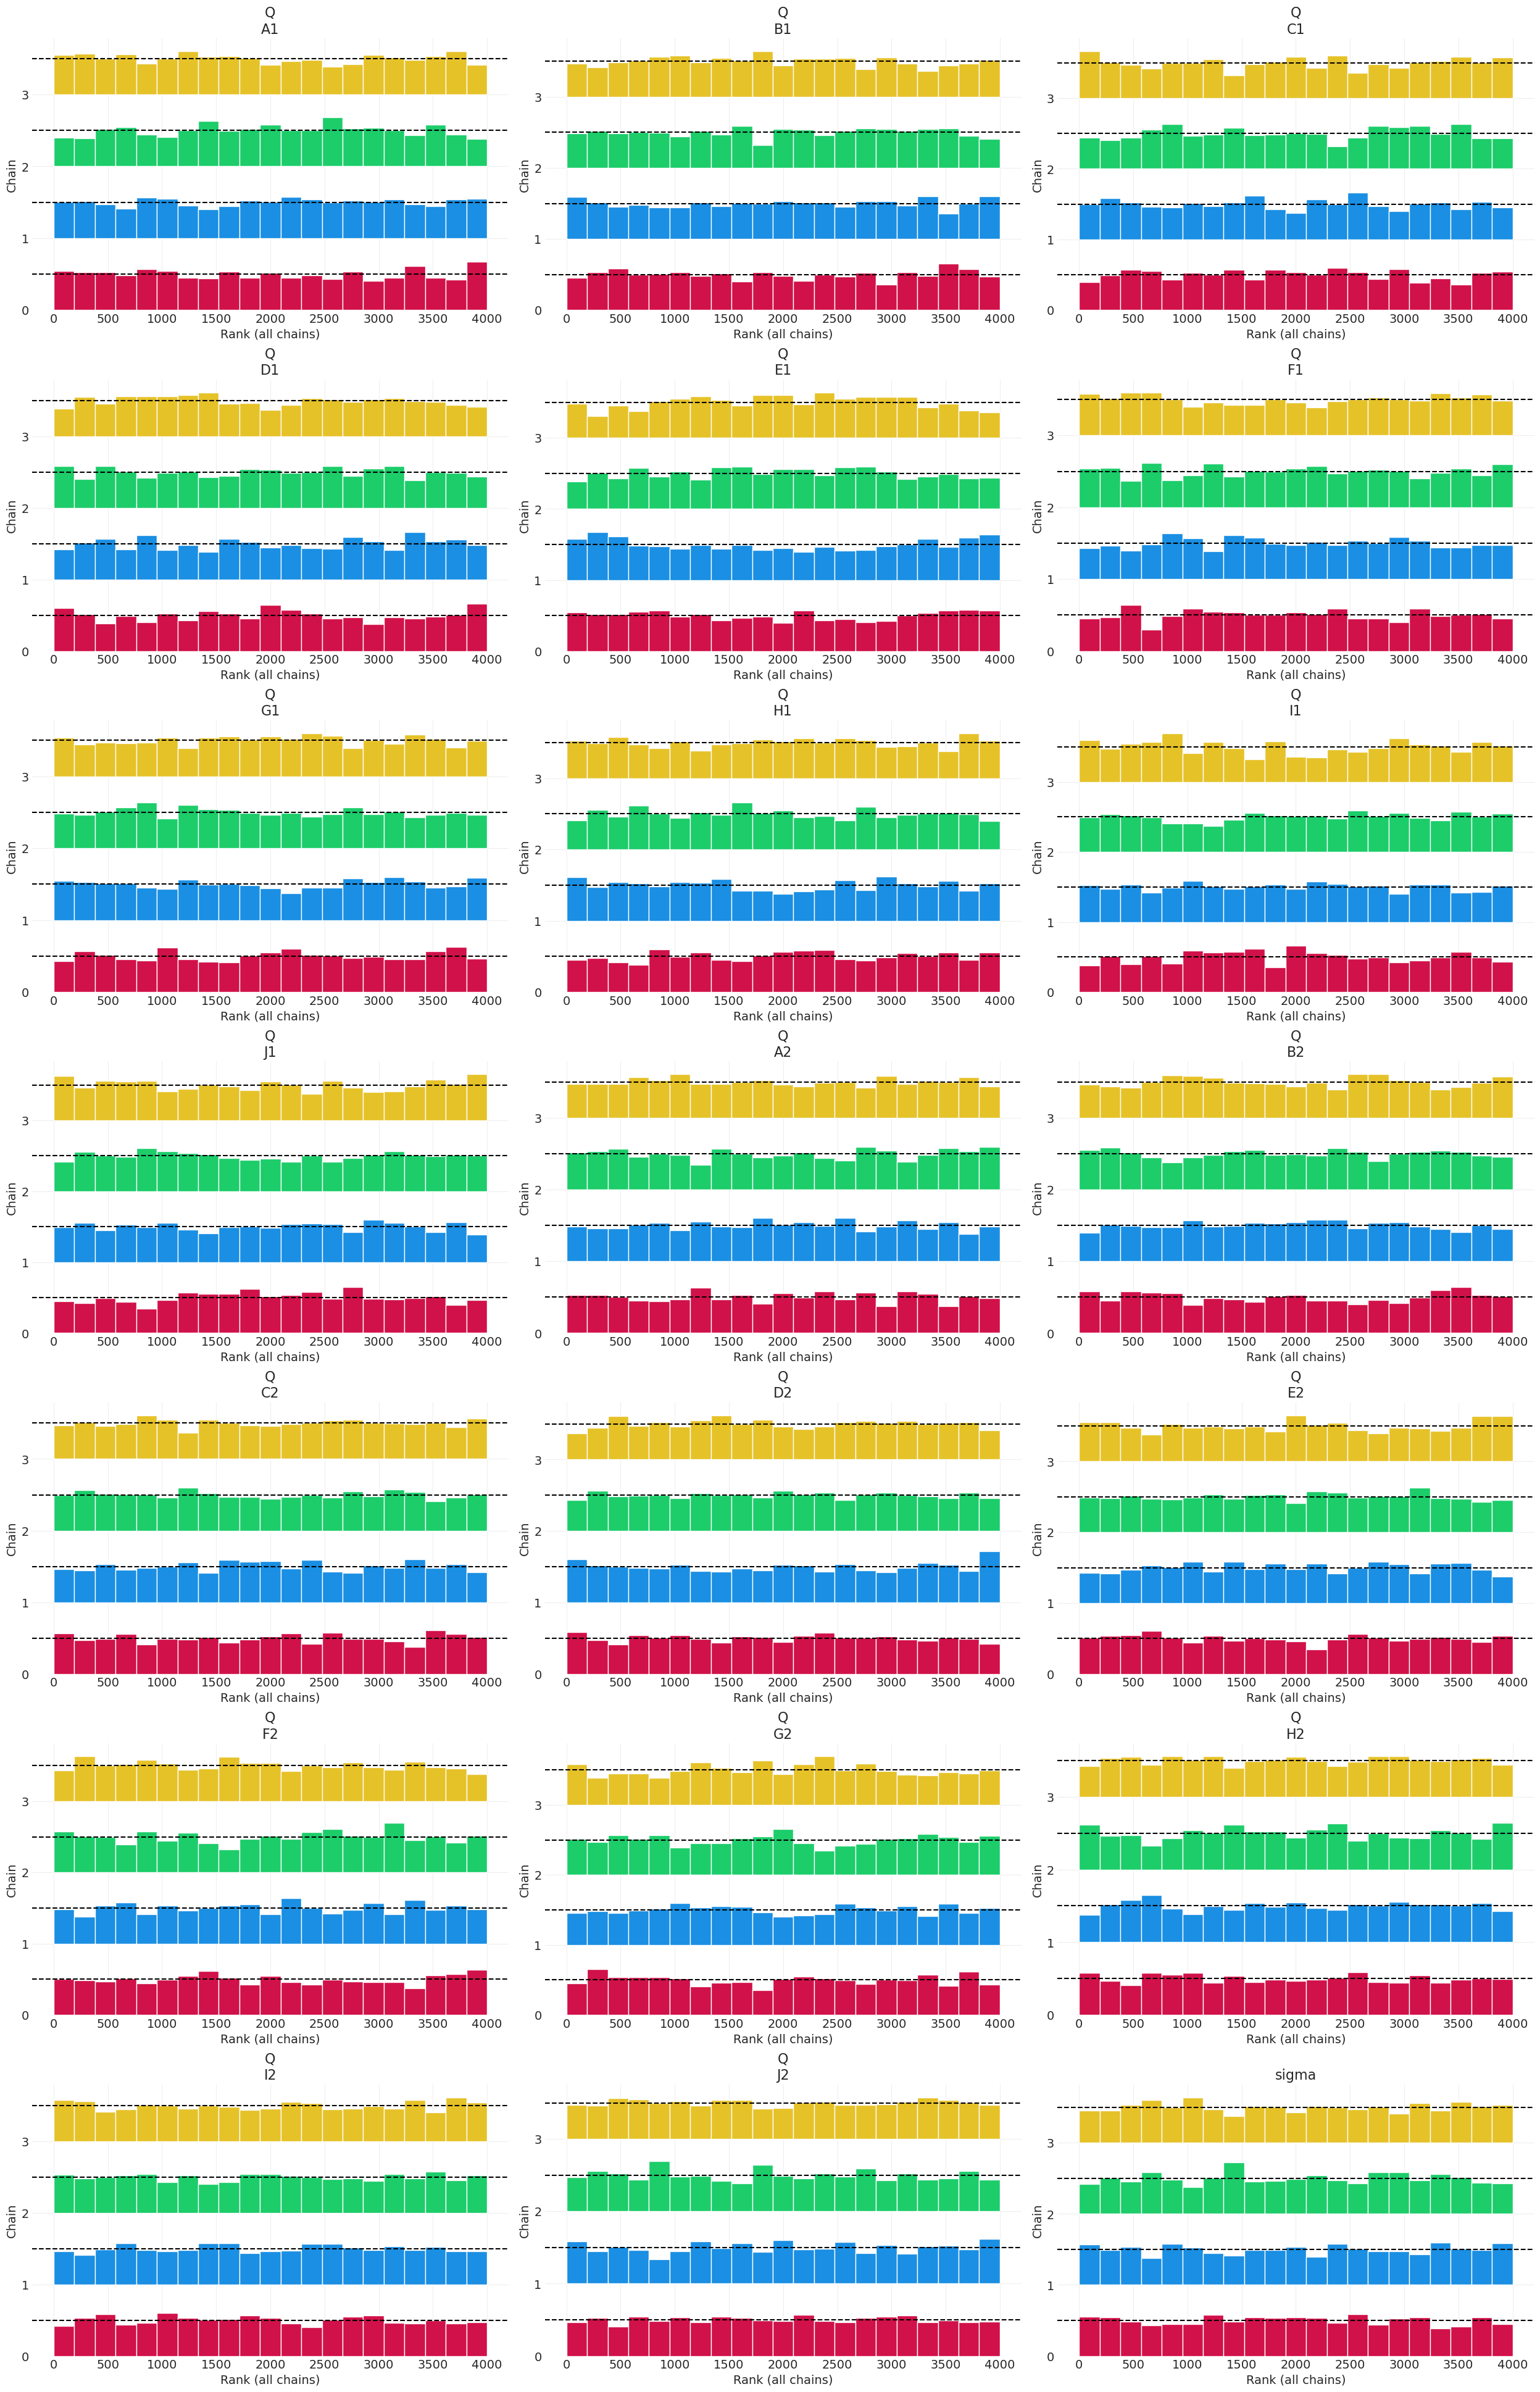

In [27]:
az.plot_rank(simple_inference);

 Having all Trank plots associated with each chain hovering over around the average (dotted lines) is indicative of a set of well-mixed, efficient, Markov chains.

## 3. R-hat
- Chain-convergence metric
- The variance ratio comparing within-chain variance to across-chain variance
- Similar (opposite) to metrics used to train k-means
- Idea is that if chains have converged, and are exploring the same space, then their within-chain variance should be more-or-less the same as the acorss-chain variance, providing an R-hat near 1.0
- No guarantees. This IS NOT A TEST.
  - no magical values; but be wary of values over 1.1 or so 🤷‍♂️

### 4. Effective Sample Size (ESS)
- the are `ess_*`, where `tail` and `bulk` are different methods for estimating the effective samples
- `tail` seems to give ESS samples after burnin
- idea is to get an estimate of the number of samples available that are close to being independent to one another
- tends to be smaller than the number of actual samples run (because actual samples aren't actually independent in real world)

#### Show diagnostics

In [28]:
az.summary(simple_inference)[["ess_bulk", "ess_tail", "r_hat"]]

ess_bulk  ess_tail  r_hat
Q[A1]   11039.0    2969.0   1.00
Q[B1]    9868.0    2969.0   1.00
Q[C1]    9702.0    2878.0   1.00
Q[D1]    8275.0    2700.0   1.00
Q[E1]   10652.0    2742.0   1.01
Q[F1]   10452.0    2963.0   1.00
Q[G1]    9953.0    3314.0   1.00
Q[H1]    7694.0    2506.0   1.00
Q[I1]    9632.0    2801.0   1.00
Q[J1]    9654.0    2855.0   1.00
Q[A2]    8660.0    3420.0   1.00
Q[B2]   11413.0    3002.0   1.00
Q[C2]   12525.0    2978.0   1.00
Q[D2]    8610.0    3113.0   1.00
Q[E2]   10737.0    2991.0   1.00
Q[F2]    9762.0    2874.0   1.00
Q[G2]   10383.0    2651.0   1.00
Q[H2]   10027.0    2909.0   1.00
Q[I2]   10050.0    2731.0   1.00
Q[J2]    9533.0    2864.0   1.00
sigma    6766.0    2798.0   1.00

#### ESS Plots
##### Local ESS Plot
- Higher local ESS the better, indicating more efficient Markov Chains
- Efficient Markov Chains should demonstrate Relative ESS values that

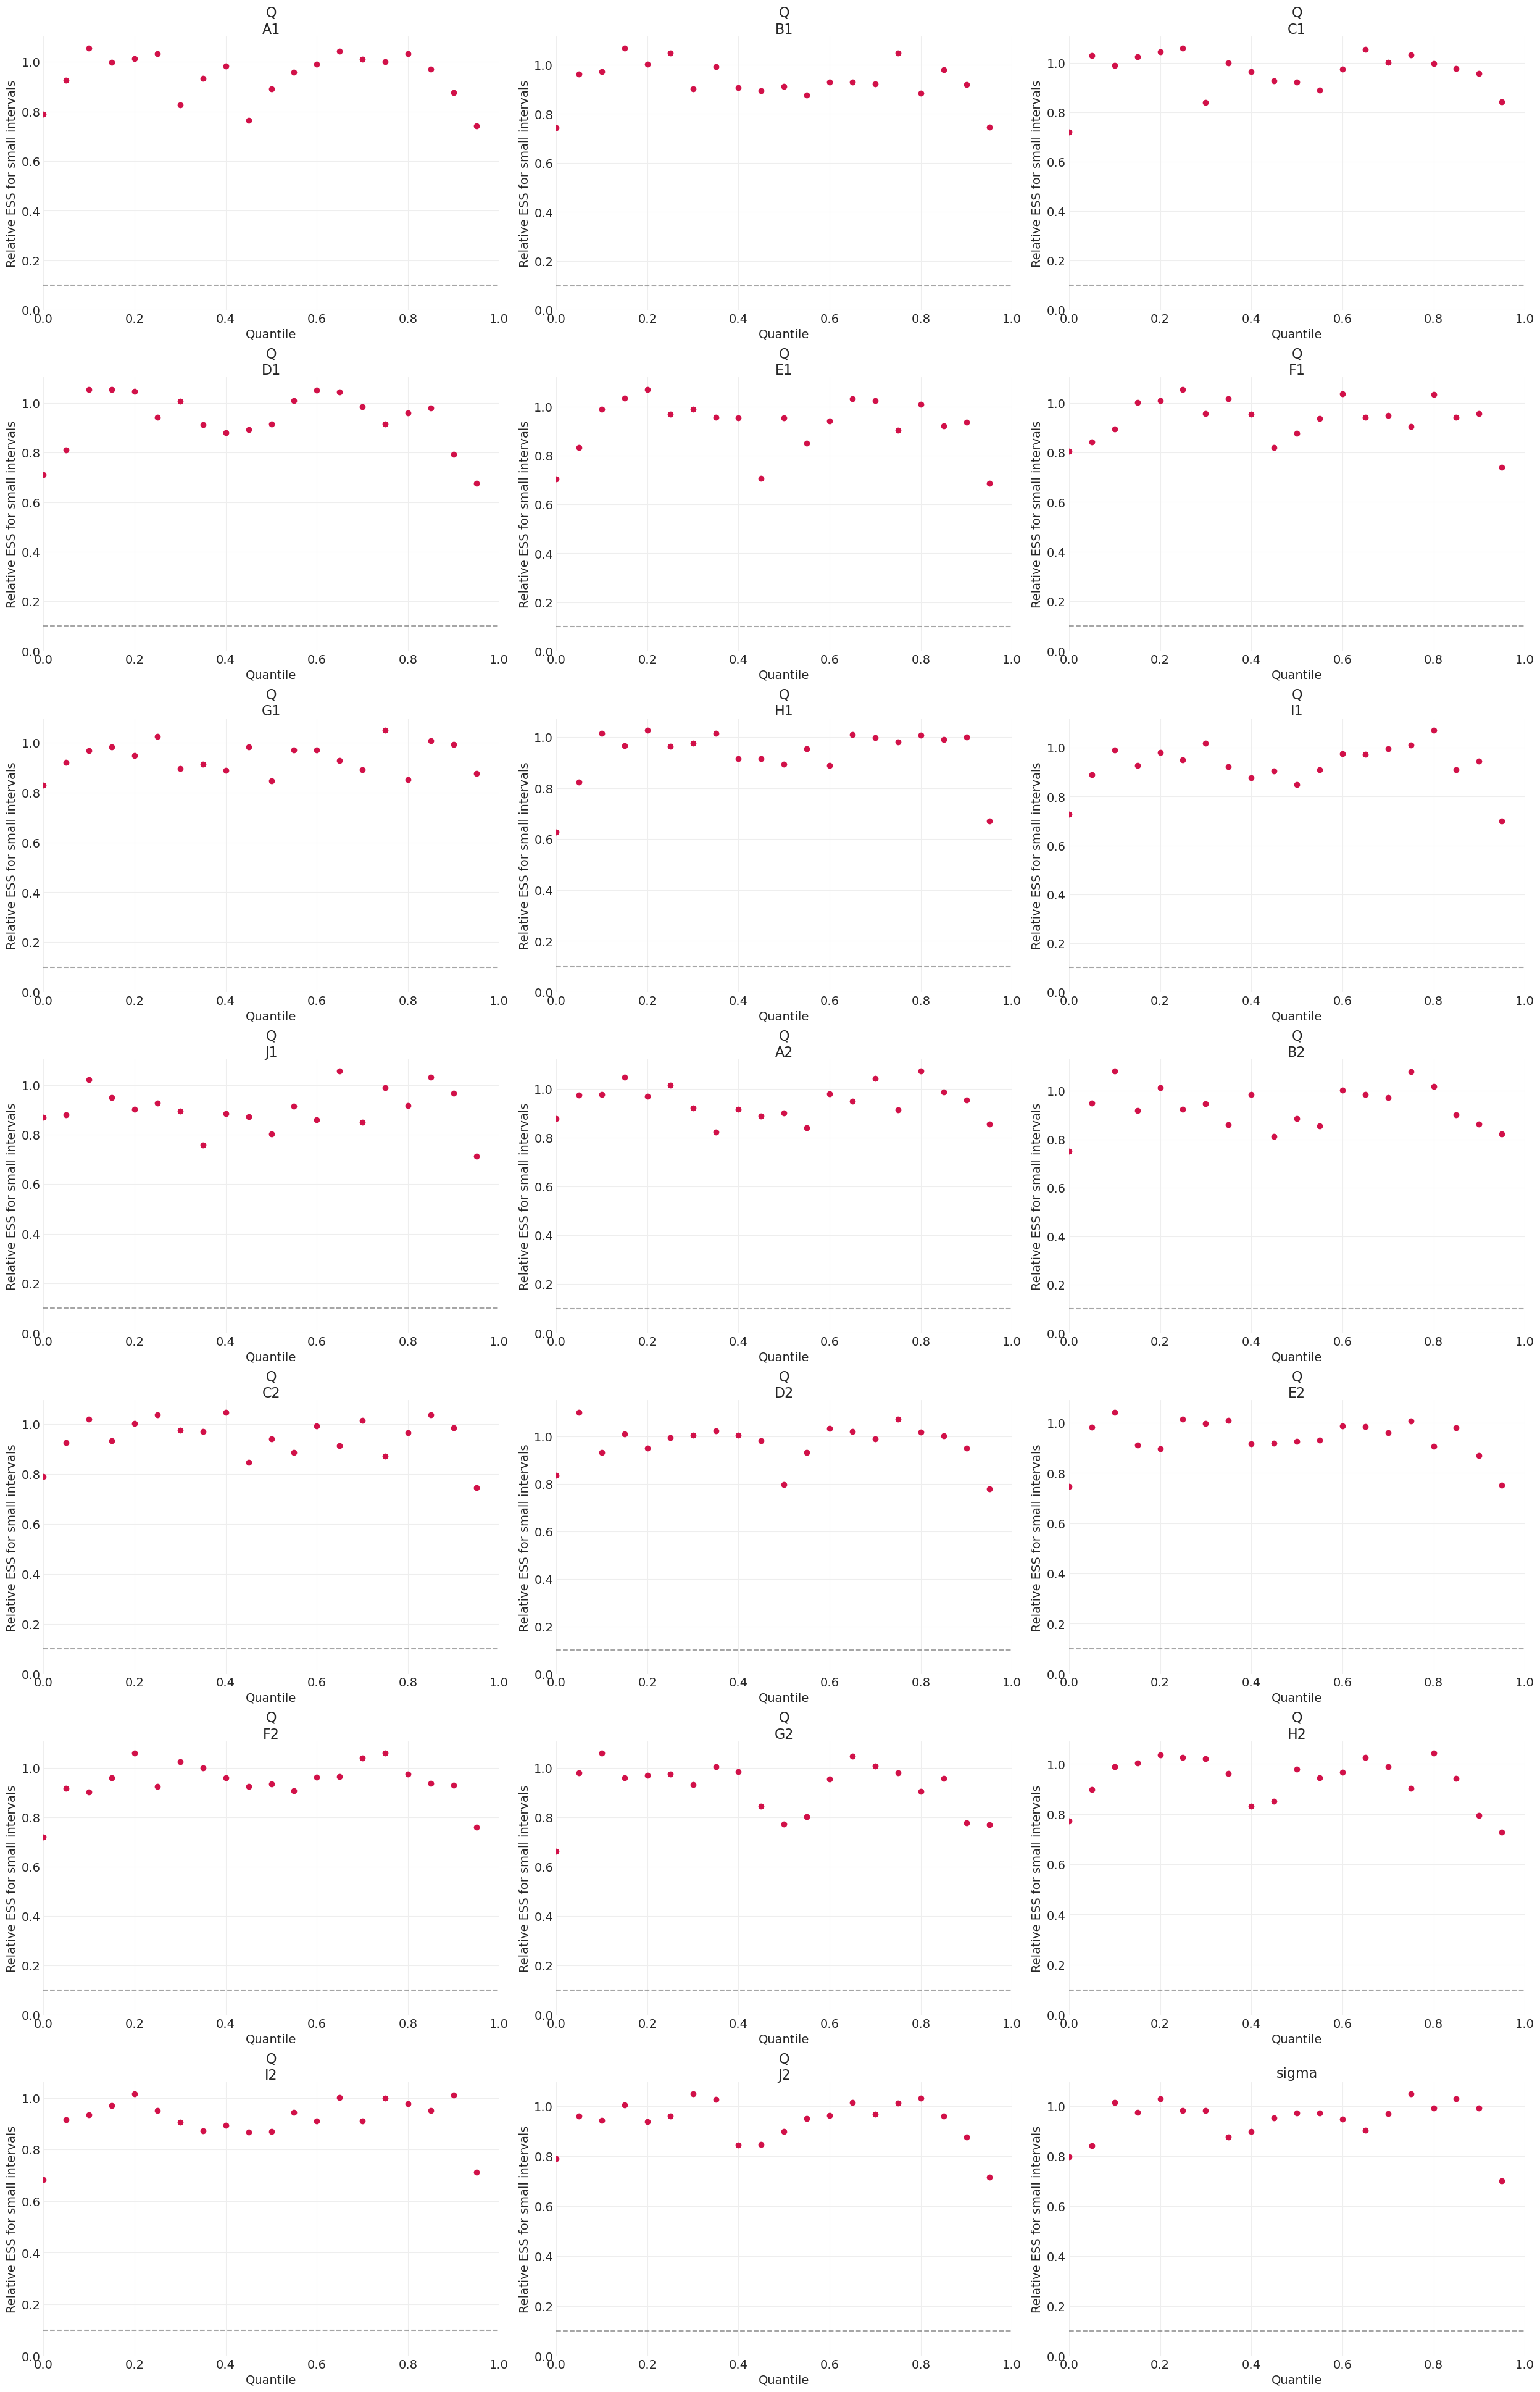

In [29]:
az.plot_ess(simple_inference, kind="local", relative=True);

##### ESS Evolution Plot
- For Markov Chains that are converging, ESS should increase consistently with the number of draws from the chain
- ESS vs draws should be roughly linear for both `bulk` and `tail`

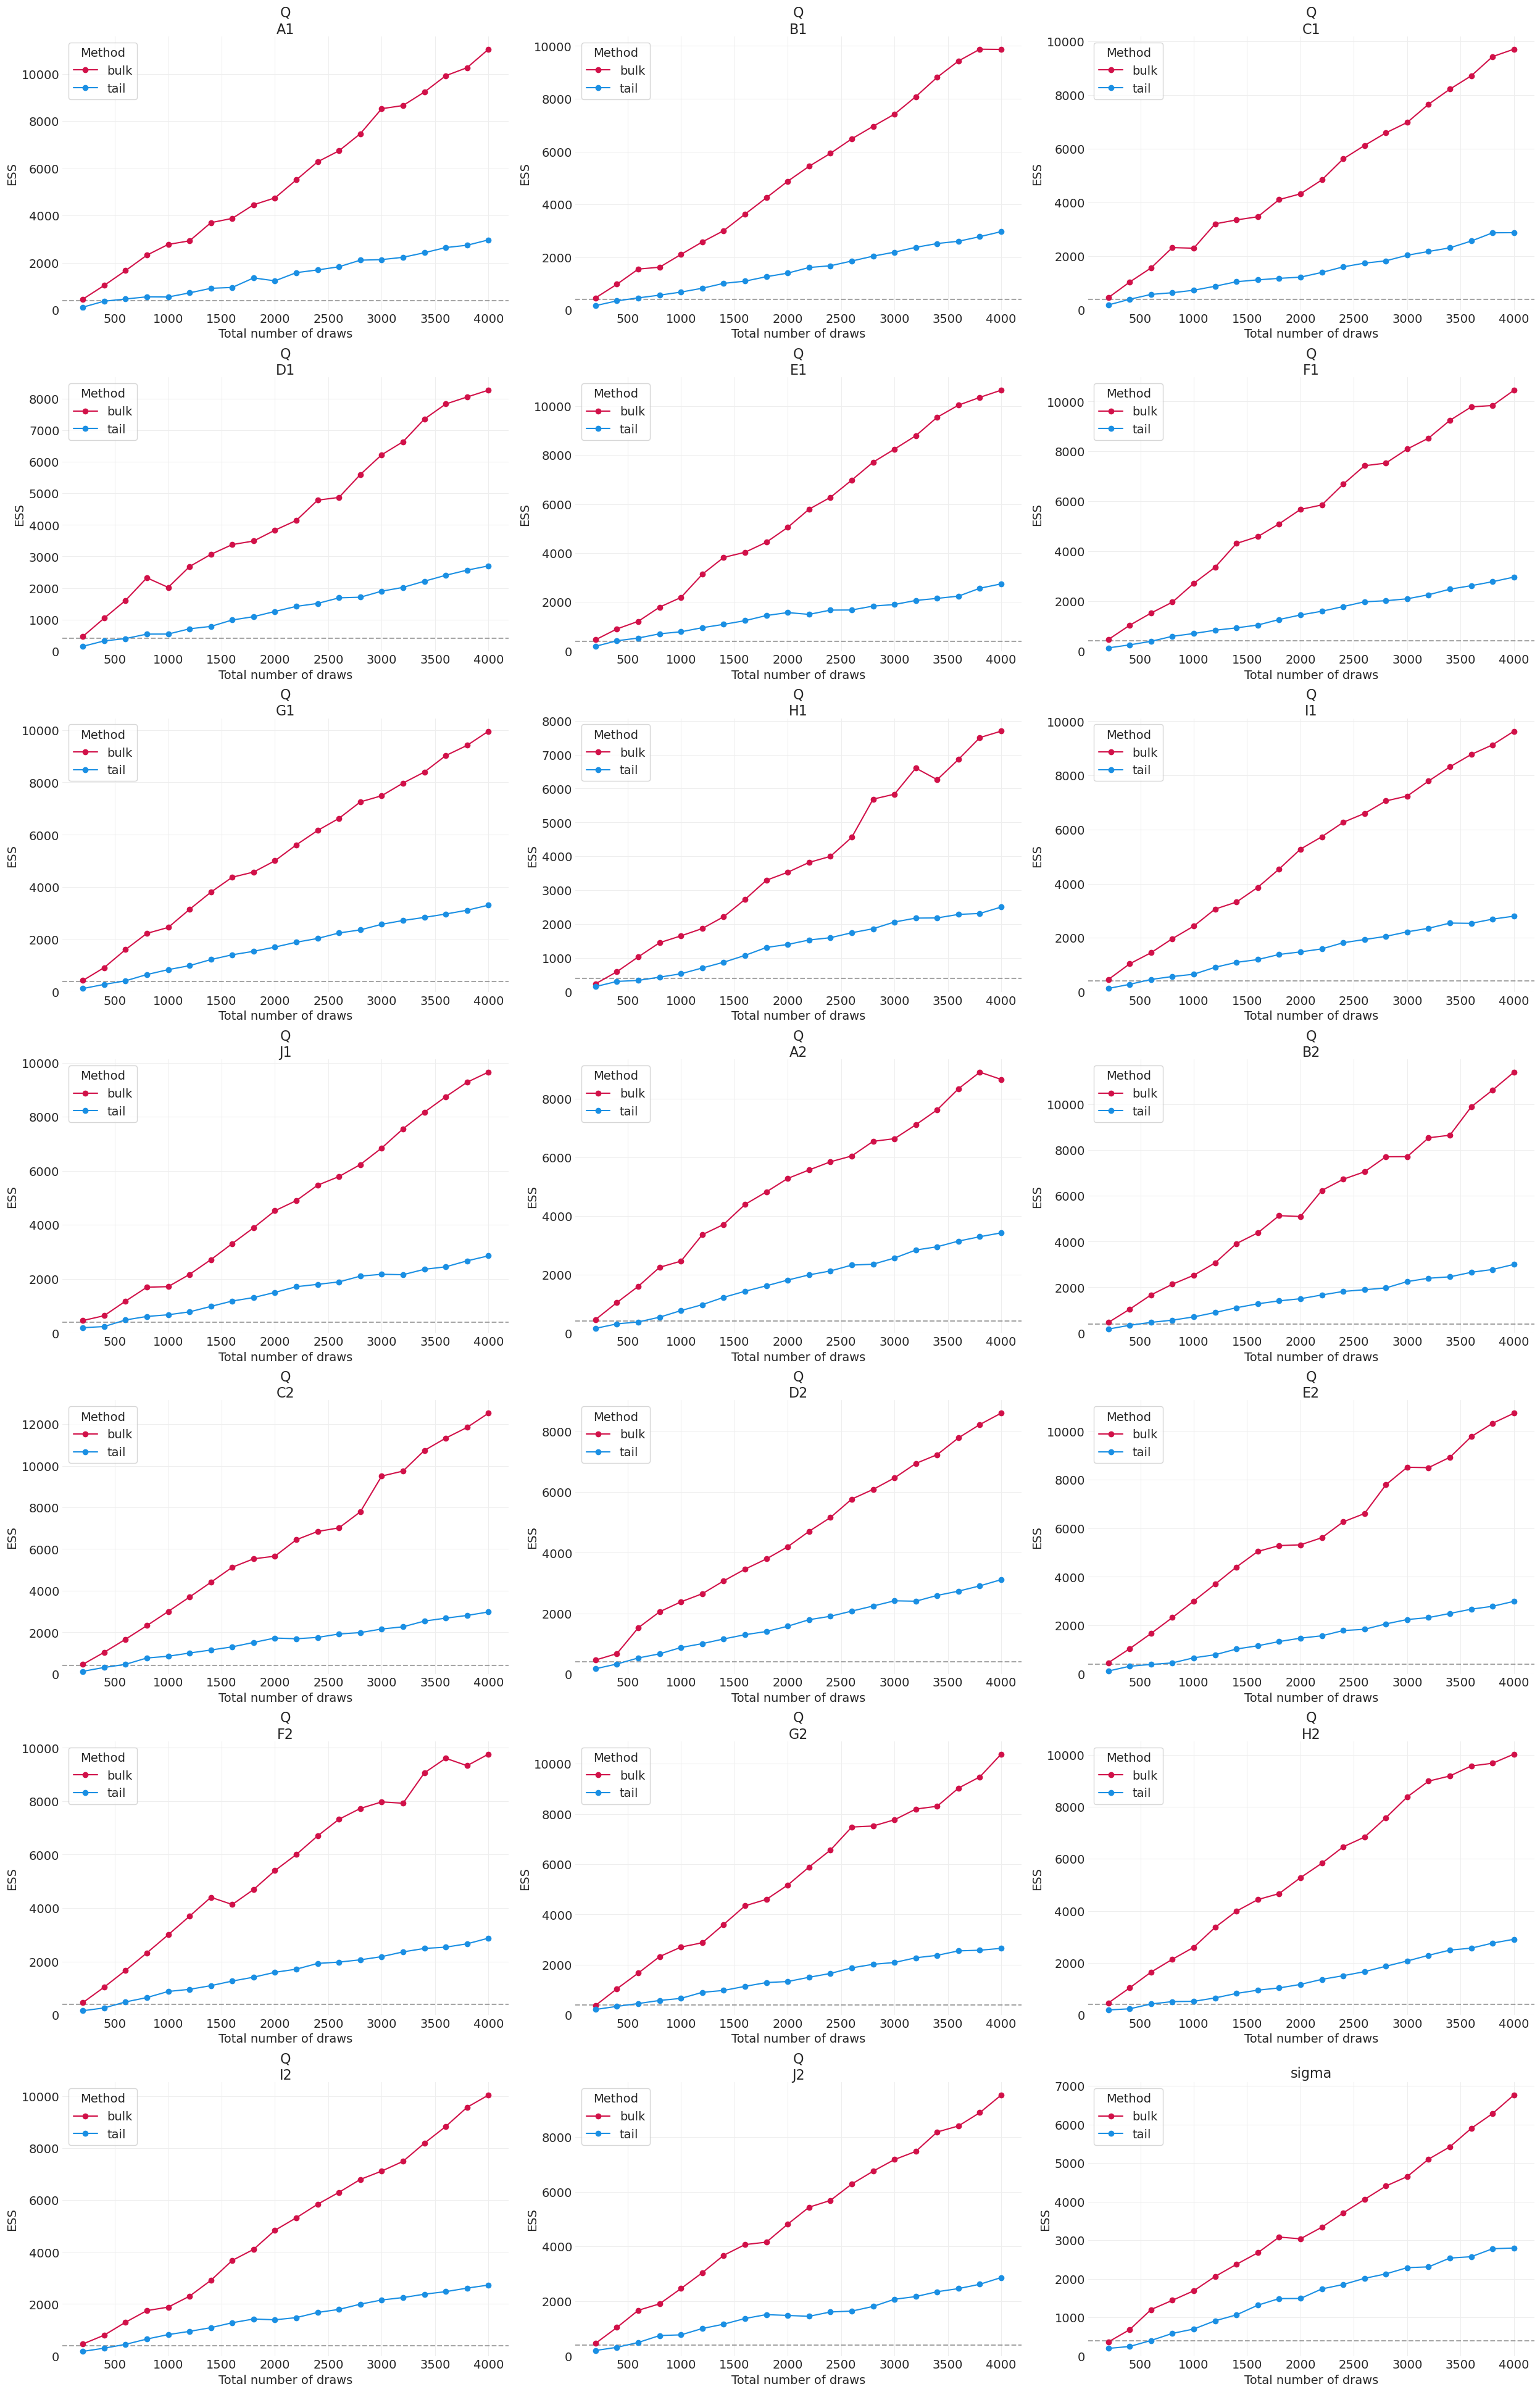

In [30]:
az.plot_ess(simple_inference, kind="evolution");

## More complete model, stratify by Wine Origin, $O_{X[i]}$

$$
\begin{align*}
S_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= Q_{W[i]} + O_{X[i]}\\
Q_{W[i]} &\sim \text{Normal}(0, 1) \\
O_{X[i]} &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$



### Fit the wine origin model

In [31]:
with pm.Model(coords={"wine": WINE, "wine_origin": WINE_ORIGIN}) as wine_origin_model:
    sigma = pm.Exponential("sigma", 1)
    O = pm.Normal("O", 0, 1, dims="wine_origin")  # Wine Origin
    Q = pm.Normal("Q", 0, 1, dims="wine")  # Wine ID
    mu = Q[WINE_ID] + O[WINE_ORIGIN_ID]
    S = pm.Normal("S", mu, sigma, observed=SCORES)

    wine_origin_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, O, Q]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### MCMC Diagnostics

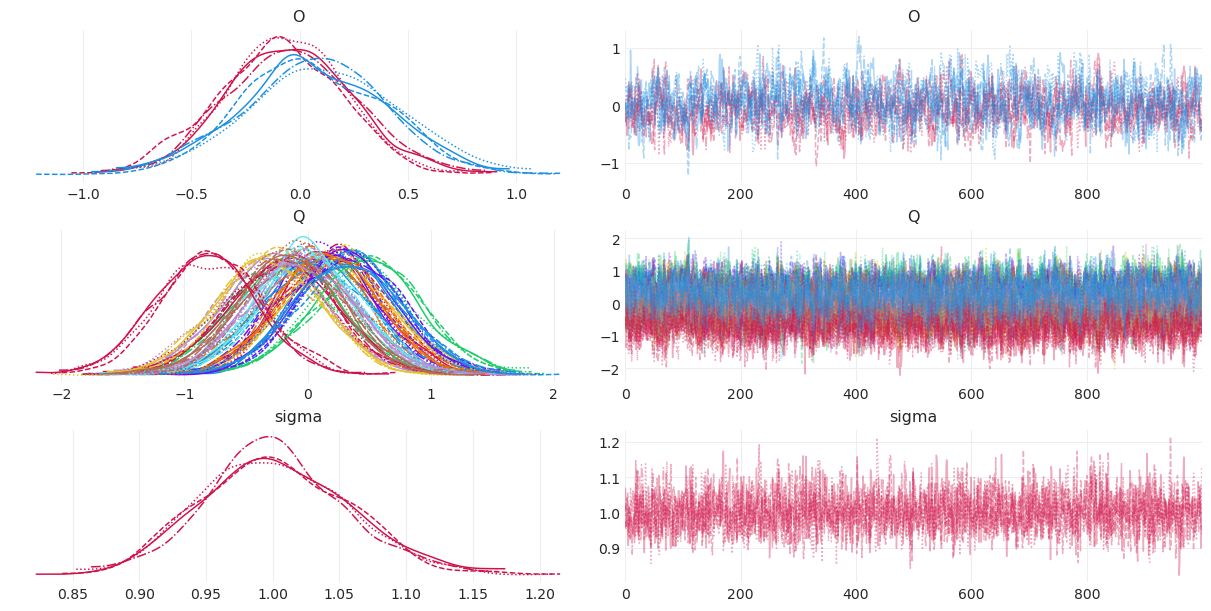

In [32]:
az.plot_trace(wine_origin_inference, compact=True);

### Posterior Summary

In [33]:
az.summary(wine_origin_inference)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
O[US] -0.061  0.290  -0.575    0.532      0.011    0.008     706.0    1243.0   
O[FR]  0.073  0.341  -0.538    0.747      0.012    0.008     824.0    1351.0   
Q[A1]  0.193  0.407  -0.561    0.966      0.012    0.008    1205.0    2143.0   
Q[B1]  0.325  0.402  -0.415    1.098      0.012    0.008    1156.0    1632.0   
Q[C1] -0.192  0.450  -1.074    0.589      0.012    0.009    1348.0    2292.0   
Q[D1]  0.224  0.448  -0.618    1.061      0.012    0.008    1428.0    2107.0   
Q[E1]  0.143  0.398  -0.567    0.915      0.011    0.008    1291.0    2448.0   
Q[F1]  0.036  0.418  -0.756    0.803      0.011    0.008    1329.0    2380.0   
Q[G1] -0.052  0.418  -0.844    0.691      0.011    0.008    1440.0    2525.0   
Q[H1] -0.287  0.439  -1.114    0.543      0.012    0.009    1250.0    2166.0   
Q[I1] -0.086  0.414  -0.876    0.677      0.012    0.008    1229.0    1955.0   
Q[J1] -0.229  0.447  -1.140    0.555      0.013    0.009    1242.0    2007.0   
Q[A2]  0.043  0.437  -0.816    0.843      0.013    0.009    1200.0    2190.0   
Q[B2]  0.484  0.443  -0.350    1.326      0.012    0.009    1360.0    2206.0   
Q[C2] -0.309  0.416  -1.072    0.472      0.011    0.008    1386.0    2037.0   
Q[D2]  0.328  0.413  -0.532    1.038      0.011    0.008    1310.0    1719.0   
Q[E2]  0.179  0.403  -0.548    0.958      0.011    0.008    1342.0    2241.0   
Q[F2]  0.022  0.408  -0.741    0.777      0.011    0.008    1352.0    1914.0   
Q[G2] -0.052  0.443  -0.894    0.768      0.012    0.009    1286.0    1871.0   
Q[H2] -0.144  0.408  -0.857    0.650      0.011    0.008    1275.0    1855.0   
Q[I2] -0.808  0.412  -1.587   -0.038      0.011    0.008    1314.0    2414.0   
Q[J2]  0.320  0.446  -0.516    1.153      0.012    0.008    1390.0    2342.0   
sigma  1.002  0.055   0.902    1.103      0.001    0.001    2914.0    3001.0   

       r_hat  
O[US]   1.01  
O[FR]   1.01  
Q[A1]   1.00  
Q[B1]   1.01  
Q[C1]   1.01  
Q[D1]   1.00  
Q[E1]   1.00  
Q[F1]   1.00  
Q[G1]   1.00  
Q[H1]   1.00  
Q[I1]   1.00  
Q[J1]   1.01  
Q[A2]   1.01  
Q[B2]   1.00  
Q[C2]   1.00  
Q[D2]   1.00  
Q[E2]   1.01  
Q[F2]   1.00  
Q[G2]   1.01  
Q[H2]   1.00  
Q[I2]   1.00  
Q[J2]   1.00  
sigma   1.00

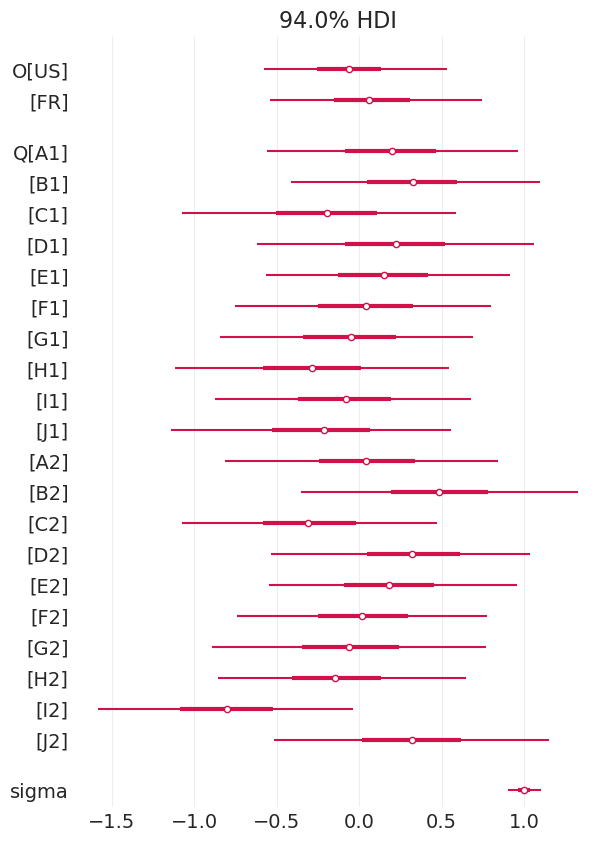

In [34]:
az.plot_forest(wine_origin_inference, combined=True);

## Including Judge Effects

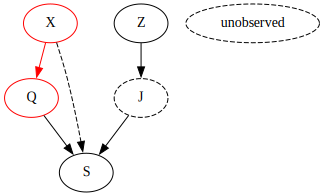

In [35]:
utils.draw_causal_graph(
    edge_list=[("Q", "S"), ("X", "Q"), ("X", "S"), ("J", "S"), ("Z", "J")],
    node_props={
        "Q": {"color": "red"},
        "J": {"style": "dashed"},
        "X": {"color": "red"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={("X", "S"): {"style": "dashed"}, ("X", "Q"): {"color": "red"}},
)

- Looking at the DAG (above), we see that judges descrimination is a competing cause of the measured score. 
- We indclude Judge effects using an **Item Response-type model** for the mean score: $\mu_i = (Q_{W[i]} + O_{X[i]} - H_{J[i]})D_{J[i]}$
- where the mean $\mu_i$ of the score $S_i$ is modeled as a linear combination of
  - wine quality $Q_{W[i]}$
  - wine origin $O_{X[i[}$
  - judge's baseline scoring harshness $H_{J[i]}$
    - values $< 0$ indicates a judge is less likely than average to judge a wine badly
  - all of this is modulated (multiplied) by the judge's discrimination ability $D_{J[i]}$
    - a value $> 1$ indicates a judge provides larger scores discrepancies for differences in wine
    - a value $< 1$ indicates a judge gives smaller scores discrepancies for differences in wine
    - a value of 0 indicates a judge gives all wines an average score
   

#### Statistical model
$$
\begin{align*}
S_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= (Q_{W[i]} + O_{X[i]} - H_{J[i]})D_{J[i]} \\
Q_{W[i]} &\sim \text{Normal}(0, 1) \\
O_{X[i]} &\sim \text{Normal}(0, 1) \\
H_{X[i]} &\sim \text{Normal}(0, 1) \\
D_{X[i]} &\sim \text{Exponential}(1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$



#### Fit the judge model

In [36]:
with pm.Model(coords={"wine": WINE, "wine_origin": WINE_ORIGIN, "judge": JUDGE}) as judges_model:

    # Judge effects
    D = pm.Exponential("D", 1, dims="judge")  # Judge Discrimination (multiplicative)
    H = pm.Normal("H", 0, 1, dims="judge")  # Judge Harshness (additive)

    # Wine Origin effect
    O = pm.Normal("O", 0, 1, dims="wine_origin")

    # Wine Quality effect
    Q = pm.Normal("Q", 0, 1, dims="wine")

    # Score
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    mu = (O[WINE_ORIGIN_ID] + Q[WINE_ID] - H[JUDGE_ID]) * D[JUDGE_ID]
    S = pm.Normal("S", mu, sigma, observed=SCORES)

    judges_inference = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D, H, O, Q, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


#### Markov Chain Diagnostics

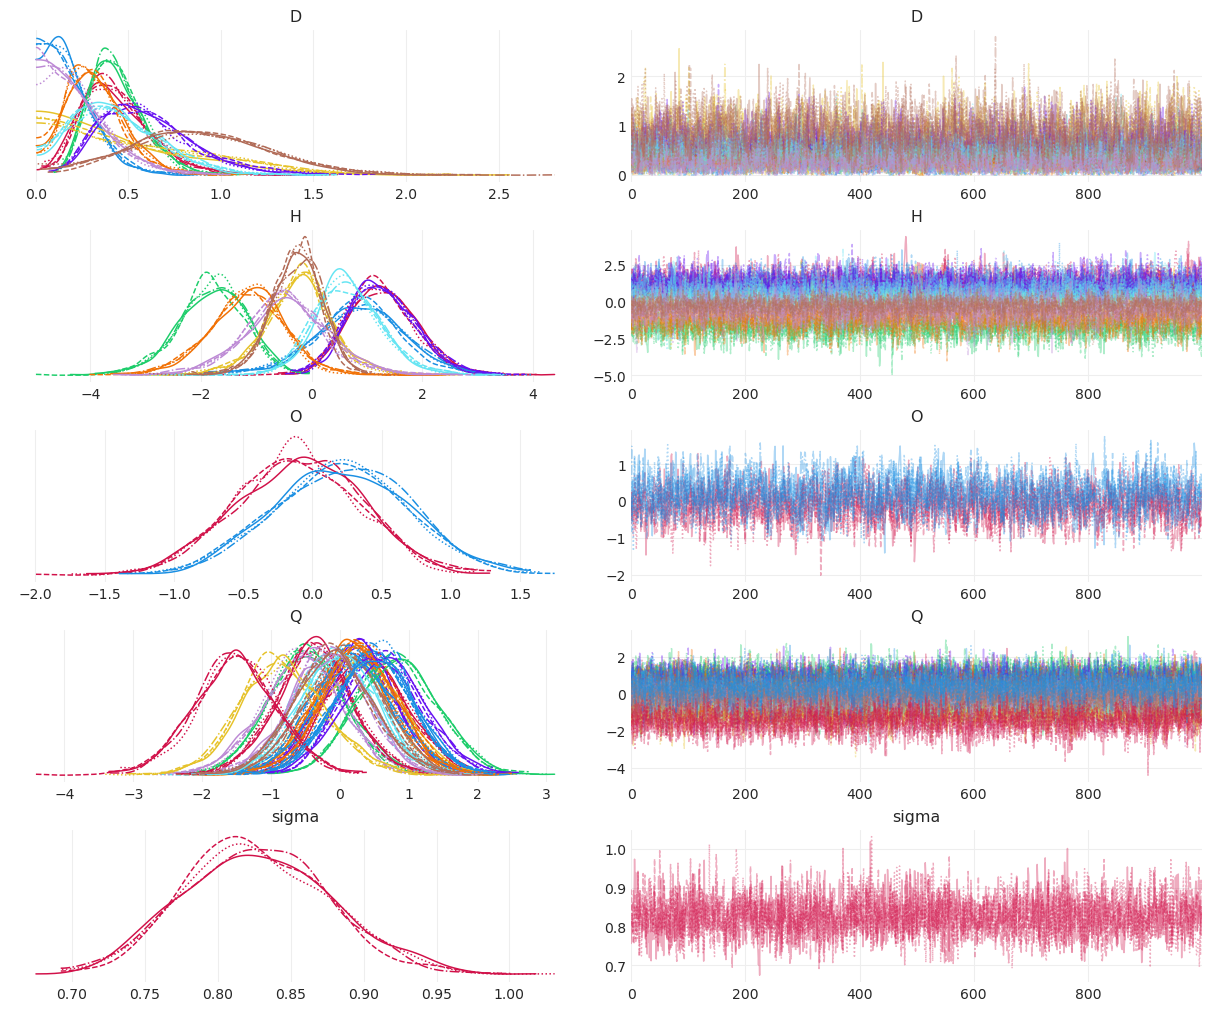

In [37]:
az.plot_trace(judges_inference, compact=True);

#### Posterior summary

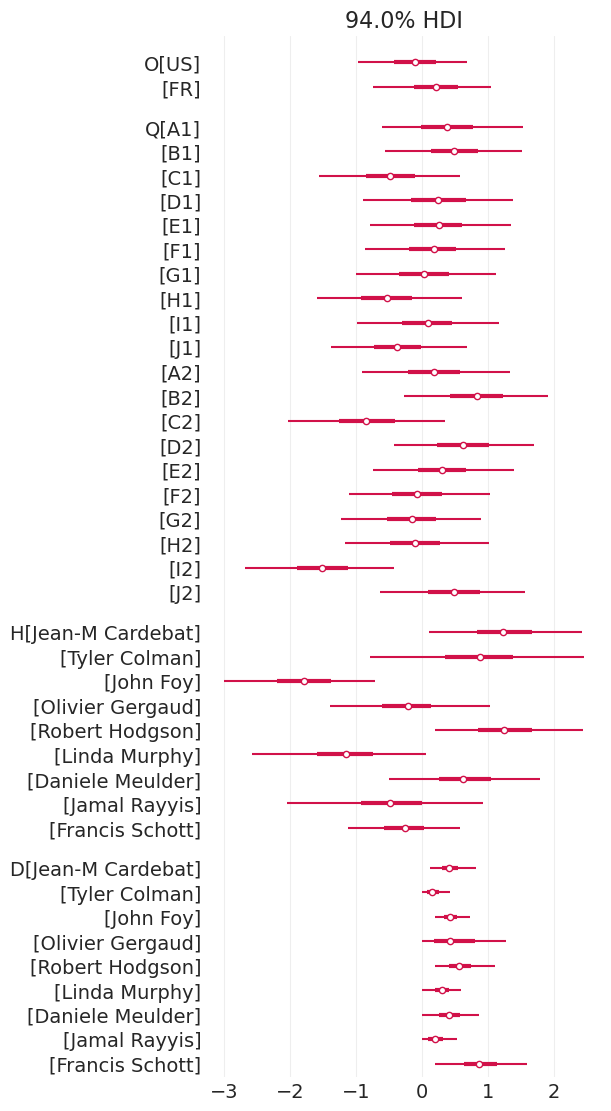

In [38]:
az.plot_forest(judges_inference, var_names=["O", "Q", "H", "D"], combined=True);

## Does Wine Origin Matter?

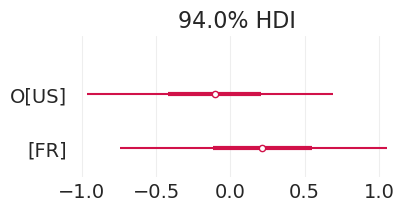

In [39]:
_, ax = plt.subplots(figsize=(4, 2))
az.plot_forest(judges_inference, combined=True, var_names=["O"], ax=ax);

**not really**, at least when comparing posterior variable for wine origin, $O$

### Calculating the contrast distribution
#### Always be contrasting

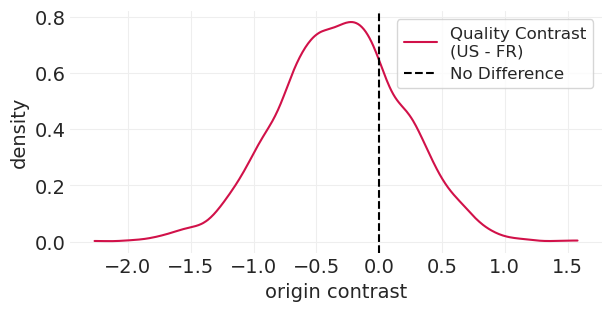

In [40]:
# Posterior contrast
plt.subplots(figsize=(6, 3))
quality_US = judges_inference.posterior.sel(wine_origin="US")
quality_FR = judges_inference.posterior.sel(wine_origin="FR")
contrast = quality_US - quality_FR

wine_origin_model_param = "O"

az.plot_dist(contrast[wine_origin_model_param], label="Quality Contrast\n(US - FR)")
plt.axvline(0, color="k", linestyle="--", label="No Difference")
plt.xlabel("origin contrast")
plt.ylabel("density")
plt.legend();

The posterior contrast supports the same results. **There is little difference--if any--between the quality of NJ and FR wine.**

### Words of Wisdom from Gelman
> When you have computational problems, often there's a problem with your model.

Pay attention to
- the scientific assumptions of your model
- priors
- variable preprocessing
- sampler settings
- Be weary of **Divergences**
  - These are HMC simulations that violate Hamiltonian conditions; unreliable proposals
  - Divergences are usually a symptom of a model that is designed incorrectly or that can be parameterized for to improve sampling efficiency (e.g. non-centered priors)
 
### Shout out to Spiegelhalter! 🐞🐛🪲
- BUGS package started the desktop MCMC revolution

## Authors
* Ported to PyMC by Dustin Stansbury (2024)
* Based on Statistical Rethinking (2023) lectures by Richard McElreath

In [41]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Tue Dec 17 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

pytensor: 2.26.4
aeppl   : not installed
xarray  : 2024.7.0

pandas     : 2.2.2
xarray     : 2024.7.0
arviz      : 0.19.0
statsmodels: 0.14.2
pymc       : 5.19.1
matplotlib : 3.9.2
numpy      : 1.26.4
scipy      : 1.14.1

Watermark: 2.5.0



:::{include} ../page_footer.md
:::